In [1]:
import numpy as np
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates

import ipywidgets as widgets
from IPython.display import clear_output

import classes
import IO

from interface import get_orbit_from, check_validity, plot_data

from sklearn import preprocessing

In [3]:
orbit = 1337
orbit = 1444

datapath='/Users/alexanderwolff/Local/processed_data'


frame, t = get_orbit_from(path=datapath, orbit=orbit)
ima, els, mag = check_validity(frame,t)

In [12]:
frame.keys()

dict_keys(['IMA', 'ELS', 'MAG'])

(<Figure size 648x432 with 3 Axes>,
 {'IMA': <matplotlib.axes._subplots.AxesSubplot at 0x7f842474d3d0>,
  'ELS': <matplotlib.axes._subplots.AxesSubplot at 0x7f8428cd0750>,
  'MAG': <matplotlib.axes._subplots.AxesSubplot at 0x7f842474db50>})

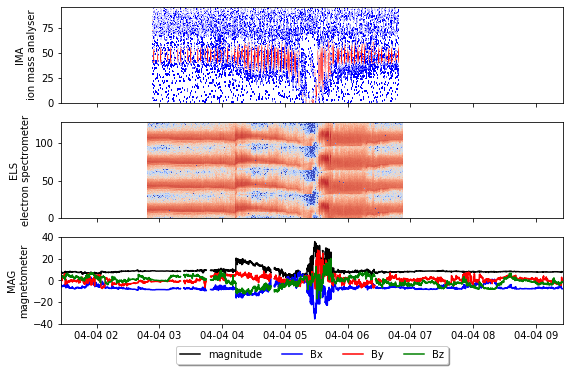

In [6]:
plot_data(frame,t)

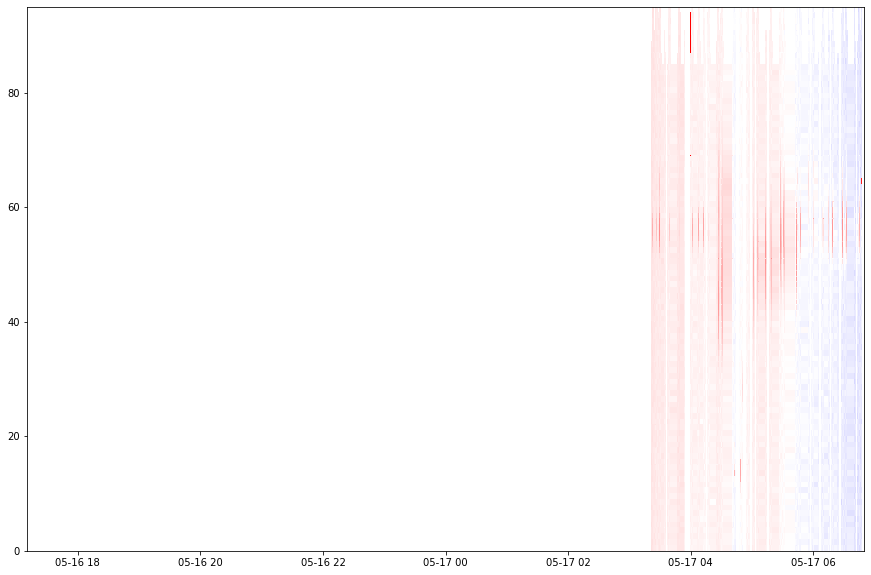

In [1366]:
ylimits = {'IMA': [0, 96], 'ELS' : [0, 128], 'MAG': [-40, 40]}

plt.figure(figsize=(15,10))
plt.pcolormesh(t['IMA'], np.arange(ylimits['IMA'][1])[::-1], np.log10(frame['IMA'].clip(1e-5)), cmap='bwr', norm=colors.LogNorm())
#plt.pcolormesh(t['ELS'], np.arange(ylimits['ELS'][1])[::-1], np.log10(frame['ELS'].clip(1e-5)), cmap='coolwarm', norm=colors.LogNorm())
plt.show()

In [66]:
# let's try to convert to a format we can display in imshow -> ELS and IMA

In [121]:
x = len(frame['IMA'].data)
y = len(frame['IMA'].data[0])

IMA = np.zeros((x,y))

for i in range(x):
    for j in range(y):
        IMA()

In [4]:
import pandas
import random
import datetime

In [5]:
# time is stored as a series

IMA = pandas.DataFrame
IMA.t = pandas.Series(t['IMA'])

orbit :635


/Users/alexanderwolff/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(<Figure size 648x432 with 3 Axes>,
 {'IMA': <matplotlib.axes._subplots.AxesSubplot at 0x7fc1c2ca3210>,
  'ELS': <matplotlib.axes._subplots.AxesSubplot at 0x7fc1ca60c250>,
  'MAG': <matplotlib.axes._subplots.AxesSubplot at 0x7fc1ca68a350>})

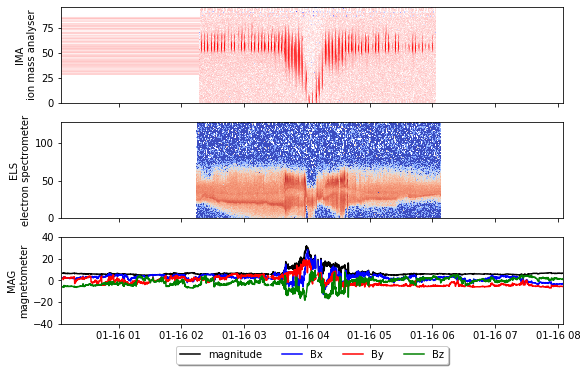

In [6]:
# ELS quadriple sample example at orbit 1269

orbit = random.randint(10,3190)
print('orbit :{}'.format(orbit))

datapath='/Users/alexanderwolff/Local/processed_data'
frame, t = get_orbit_from(path=datapath, orbit=orbit)

plot_data(frame,t)

In [7]:
instrument = 'ELS'
print('instrument :{}'.format(instrument))
time_diff = pandas.Series([t[instrument][i+1]-t[instrument][i] for i in range(len(t[instrument])-1)])
print('\n')
try:
    print('Min Sample Delay:  {}'.format(time_diff.min().round('1s')))
    print('Mean Sample Delay: {}'.format(time_diff.mean().round('1s')))
    print('Max Sample Delay:  {}'.format(time_diff.max().round('1s')))
    print('\n')

    buckets = dict()
    for i in range(len(time_diff)):

        x = time_diff[i].round('1s')

        try:
            buckets[x] = buckets[x]+1
        except:
            buckets[x] = 1

    [print('sample delay : {} \t events {}'.format(key.seconds, buckets[key])) for key in buckets.keys()]
except:
    print('instrument not found')

instrument :ELS


Min Sample Delay:  0 days 00:00:04
Mean Sample Delay: 0 days 00:00:05
Max Sample Delay:  0 days 00:00:08


sample delay : 4 	 events 2610
sample delay : 8 	 events 434


In [8]:
# assuming that true sample rate is the most common

# invert key and values 
stekcub = dict()
for key in buckets.keys():
    stekcub[buckets[key]] = key
    
sample_rate = stekcub[max(stekcub)]
#sample_rate = datetime.timedelta(seconds=12)

print('sample rate : {} s = {:.3} Hz'.format(sample_rate.seconds, 1/sample_rate.seconds))

data_index = list()

section = list()
section.append(0)

# maximum amounts of samples skipped in a row before initiating new section
max_skip = 5

for i in range( len(time_diff) ):
    
    sample = i+1 #t[instrument][i+1]
    
    time_difference = time_diff[i].round('1s')
    
    # skip when no time has passed (assume error)
    if time_difference.seconds==0:
        continue
    
    if time_difference==sample_rate:
        section.append(sample)
    else:
        
        skip = int(time_difference.seconds/sample_rate.seconds)
        if skip <= max_skip:
                for j in range(skip-1):
                    section.append(None)
                section.append(sample)
        else:
            data_index.append(section)
            section = list()
            section.append(sample)
data_index.append(section)

print('sections : {} of length : \n'.format(len(data_index)))
x=[print(len(data_index[i])) for i in range(len(data_index))]

sample rate : 4 s = 0.25 Hz
sections : 1 of length : 

3479


In [1821]:
#x=[print('[{}]{}'.format(i,time_diff[i].round('1s').seconds/sample_rate.seconds )) for i in range(len(time_diff))]

In [1438]:
#x=[print('[{}]{}{}'.format(i,time_diff[i].round('1s'), '\tXXX' if time_diff[i].round('1s').seconds==0 else ' <--' 
#       if time_diff[i].round('1s')>sample_rate else '')) for i in range(len(time_diff))]


In [9]:
# transpose IMA and ELS
reframe = dict()
reframe[instrument] = frame[instrument].transpose()

time = dict()
time[instrument] = list()

dataframe = dict()
dataframe[instrument] = list()

empty = [None for i in range(len(reframe[instrument][0]))]

for section in data_index:
    
    data = list()
    data_time = list()
    
    for data_point in section:
        
        if data_point == None:
            data.append(empty)
            data_time.append(data_time[len(data_time)-1]+datetime.timedelta(seconds=sample_rate.seconds))
            
        else:
            data.append(reframe[instrument][data_point])
            data_time.append(t[instrument][data_point])
 

    dataframe[instrument].append( pandas.DataFrame(data, index=pandas.Series(data_time)) )
    time[instrument].append( pandas.Series(data_time) )
    
pandas.options.display.max_columns = 10
pandas.options.display.max_rows = None

In [10]:
for i, section in enumerate(dataframe[instrument]):
    dataframe[instrument][i] = section.interpolate()

In [18]:
samples = list()

starts = list()
ends = list()

for i, section in enumerate(dataframe[instrument]):
    
    end = len(section)
    
    amount_of_samples = 1+np.ceil((section.index[end-1]-section.index[0]).seconds/sample_rate.seconds).astype(int)
    
    starts.append(section.index[0])
    ends.append(section.index[end-1])
    
    samples.append(amount_of_samples)
    
    print("section {} \t starts at {} ends at {} : total of {} samples".format(i, 
                                        section.index[0], section.index[end-1], amount_of_samples))    

section 0 	 starts at 2008-01-16 02:14:56.663000 ends at 2008-01-16 06:07:56.881000 : total of 3496 samples


In [12]:
max_loss = 100
final_sample=list()

for i, section in enumerate(dataframe[instrument]):
    
    
    if i == 0:
        continue
    else:
        
        gap = starts[i]-ends[i-1]
        
        lost_samples = np.floor(gap.seconds/sample_rate.seconds).astype(int)
        
        samples.append(lost_samples)
        
        verdict = lost_samples<max_loss
        final_sample.append(verdict)
        
        print("[{}]\t{}-{} \t are {} seconds apart ({} lost samples)".format("O" if verdict else "X",i-1, i, gap.seconds, lost_samples))

In [13]:
combined_section_lengths = list()
combined_section_lengths.append(len(dataframe[instrument][0]))

group = list()
group.append(0)

for i in range(len(final_sample)):
    
    verdict = final_sample[i]
    
    group_index = len(group)-1
    group_number = group[group_index]
    
    if verdict:
        index = len(combined_section_lengths)-1
        combined_section_lengths[index]+=(len(dataframe[instrument][i+1]))
        group.append(group_number)
    else:
        combined_section_lengths.append(len(dataframe[instrument][i+1]))
        group.append(group_number+1)
        
largest_combined_section = combined_section_lengths.index(max(combined_section_lengths))
approved_section_start = group.index(largest_combined_section)
approved_section_end   = len(group)-group[::-1].index(largest_combined_section)
approved_section = dataframe[instrument][approved_section_start:approved_section_end]

In [19]:
depth = len(dataframe[instrument][0].T)
NoneSlice = [None for i in range(depth)]

combined_section = pandas.DataFrame()

for i, section in enumerate(approved_section):
    
    start = section.index[i]
    
    if i > 0:
        gap = start-end
        
        lost_samples = np.floor(gap.seconds/sample_rate.seconds).astype(int)
        
        last_time = end;
        
        for j in range(lost_samples):
            last_time = last_time+datetime.timedelta(seconds=sample_rate.seconds)
            missing_data = pandas.DataFrame({last_time:NoneSlice}).T
            combined_section=combined_section.append(missing_data)
    
    end = section.index[len(section)-1]
    
    combined_section=combined_section.append(section)    

In [15]:
# IMA instrument periodicity
periodicity = 8

sliced_combined_section = list()

for i in range(periodicity):
    D = combined_section
    a = [i for i in range(len(D))]
    D = D.iloc[[x+i for x in a[::8]],:]
    
    sliced_combined_section.append(D)


IndexError: positional indexers are out-of-bounds

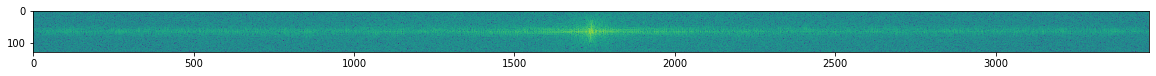

In [16]:
image = combined_section


f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.figure(figsize=(20,10))
plt.imshow(magnitude_spectrum.T)
plt.show()


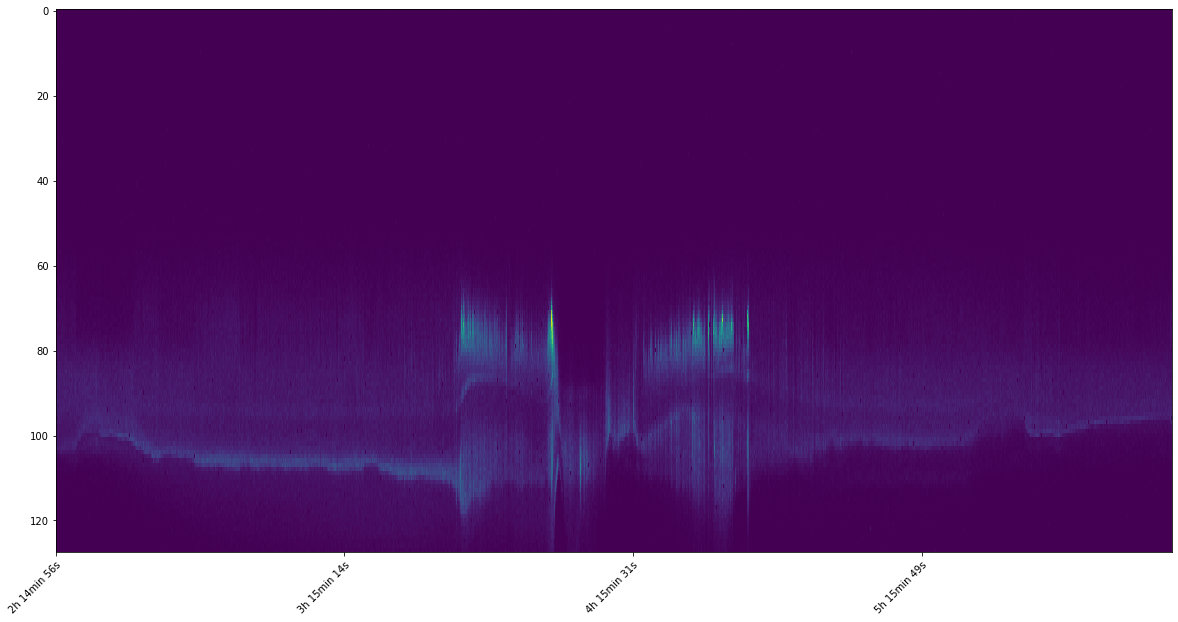

In [20]:
image = combined_section.T
T = combined_section.index
fig, ax = plt.subplots(figsize=(20,10))
im = ax.imshow(image, interpolation='nearest', aspect='auto')
ticks = np.round((60*60)/sample_rate.seconds).astype(int)
ax.set_xticks(np.arange(0, len(T), ticks))
ax.set_xticklabels(["{}h {}min {}s".format(Y.hour, Y.minute, Y.second) for Y in T[np.arange(0, len(T), ticks)]])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.xlim([0, len(T)])
plt.show()

In [21]:
image = approved_section.T
T = combined_section.index
fig, ax = plt.subplots(figsize=(20,10))
im = ax.imshow(image, interpolation='nearest', aspect='auto')
ticks = np.round((60*60)/sample_rate.seconds).astype(int)
ax.set_xticks(np.arange(0, len(T), ticks))
ax.set_xticklabels(["{}h {}min {}s".format(Y.hour, Y.minute, Y.second) for Y in T[np.arange(0, len(T), ticks)]])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.xlim([0, len(T)])
plt.show()

AttributeError: 'list' object has no attribute 'T'

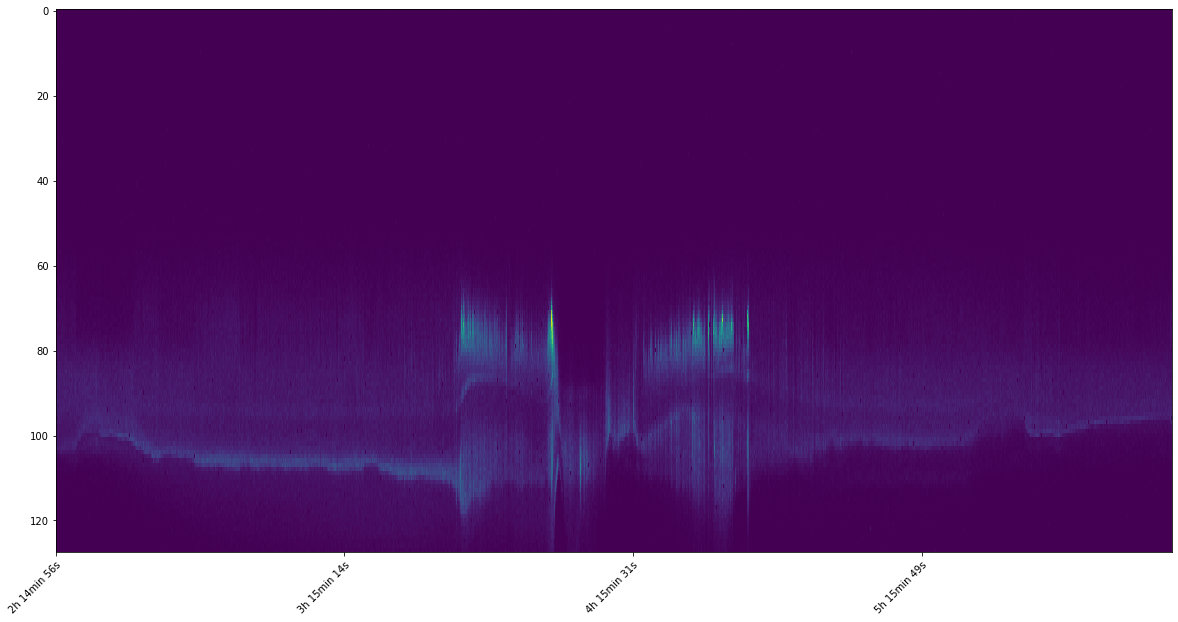

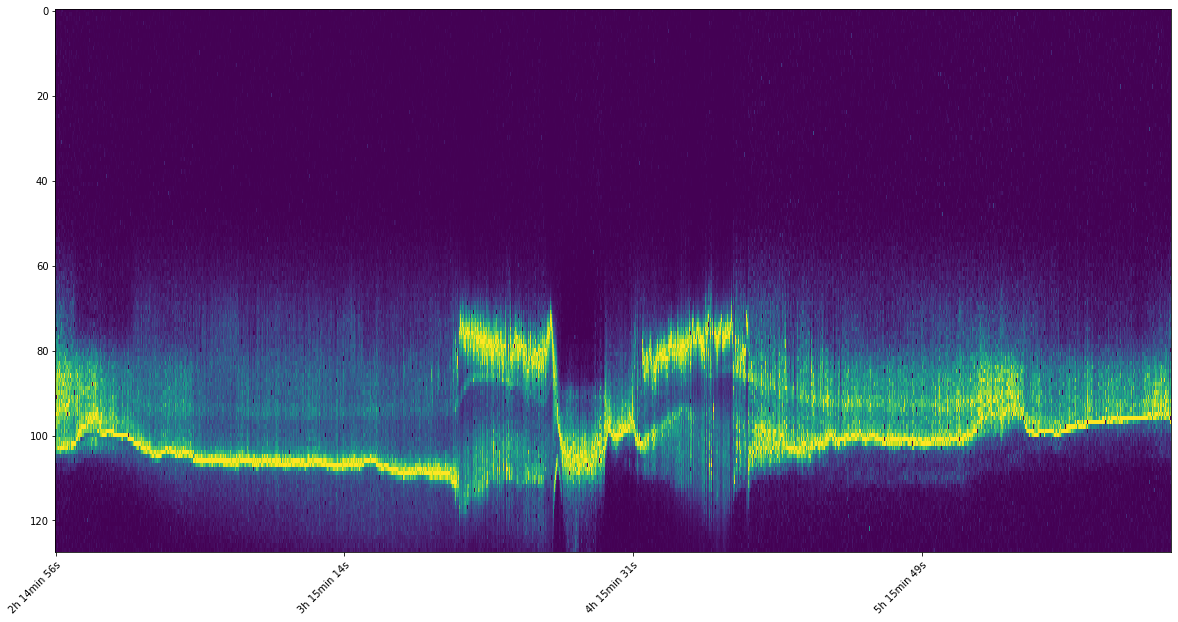

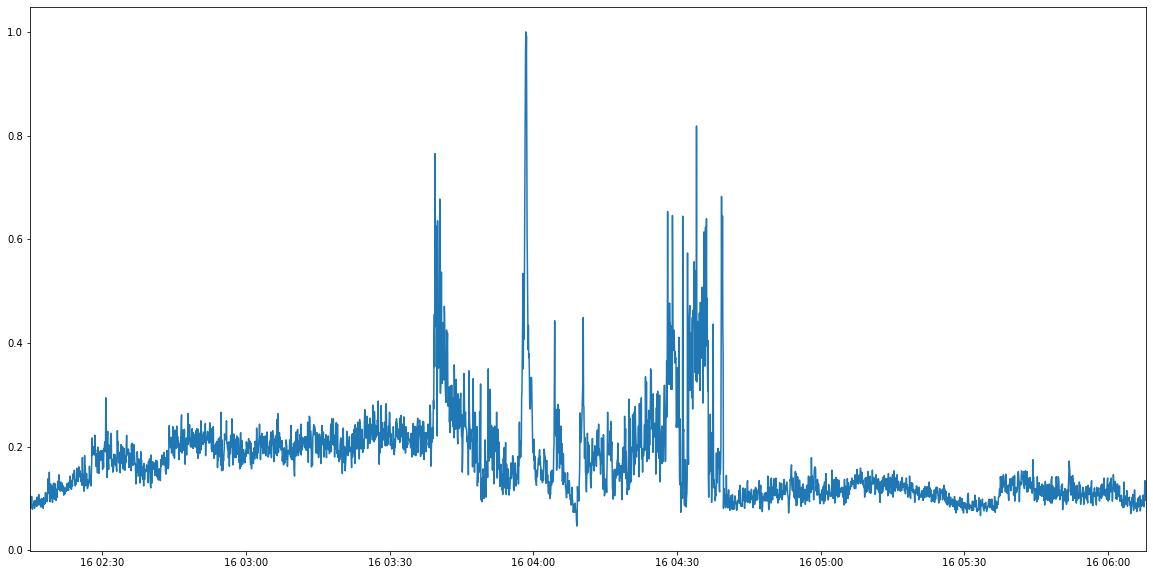

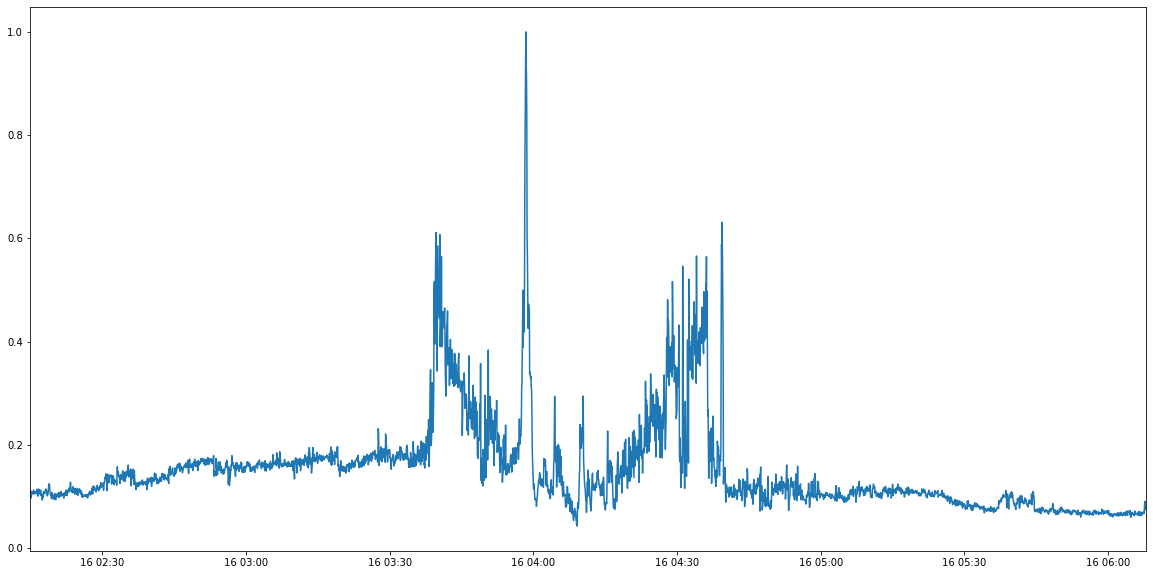

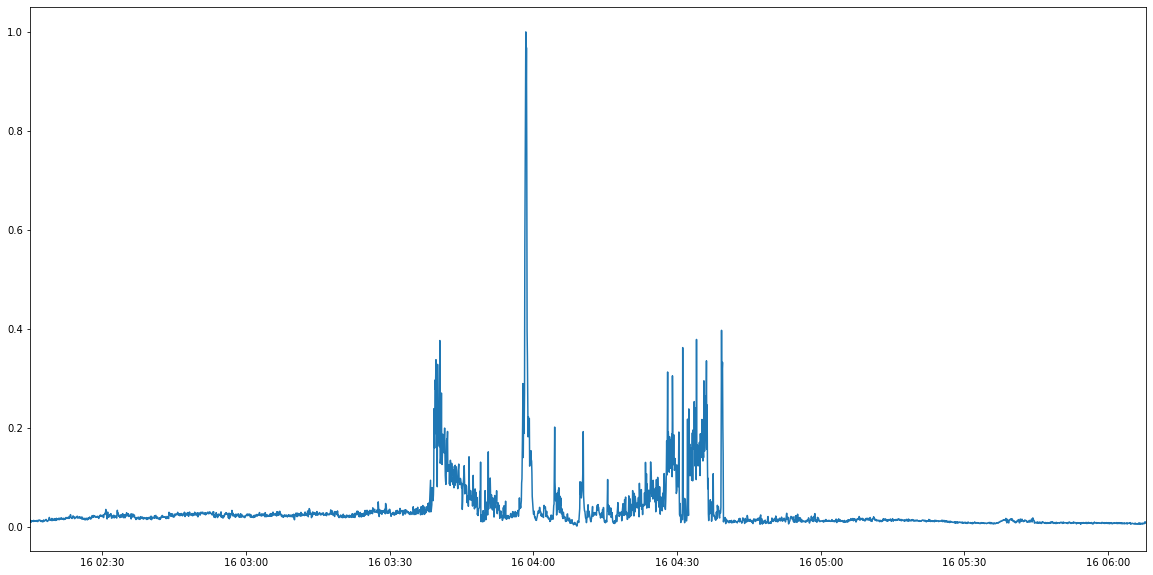

In [22]:
image = combined_section.T
T = image.T.index


x = image
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled_image = pandas.DataFrame(x_scaled)


fig, ax = plt.subplots(figsize=(20,10))
im = ax.imshow(image, interpolation='nearest', aspect='auto')
ticks = np.round((60*60)/sample_rate.seconds).astype(int)
ax.set_xticks(np.arange(0, len(T), ticks))
ax.set_xticklabels(["{}h {}min {}s".format(Y.hour, Y.minute, Y.second) for Y in T[np.arange(0, len(T), ticks)]])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.xlim([0, len(T)])
plt.show()

fig, ax = plt.subplots(figsize=(20,10))
im = ax.imshow(scaled_image, interpolation='nearest', aspect='auto')
ticks = np.round((60*60)/sample_rate.seconds).astype(int)
ax.set_xticks(np.arange(0, len(T), ticks))
ax.set_xticklabels(["{}h {}min {}s".format(Y.hour, Y.minute, Y.second) for Y in T[np.arange(0, len(T), ticks)]])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.show()

plt.figure(figsize=(20,10))
trace = image.max()
plt.plot(trace/trace.max())
plt.xlim([T[0], T[len(T)-1]])
plt.show()

plt.figure(figsize=(20,10))
trace = image.mean()
plt.plot(trace/trace.max())
plt.xlim([T[0], T[len(T)-1]])
plt.show()

plt.figure(figsize=(20,10))
trace = image.var()
plt.plot(trace/trace.max())
plt.xlim([T[0], T[len(T)-1]])
plt.show()

PART 0


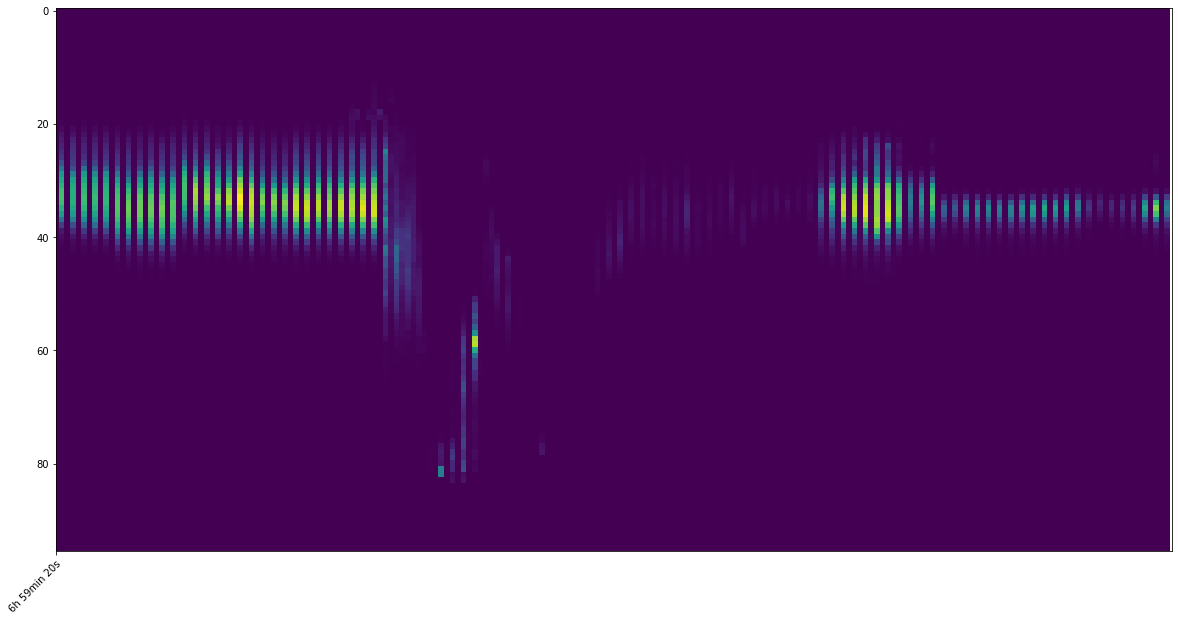

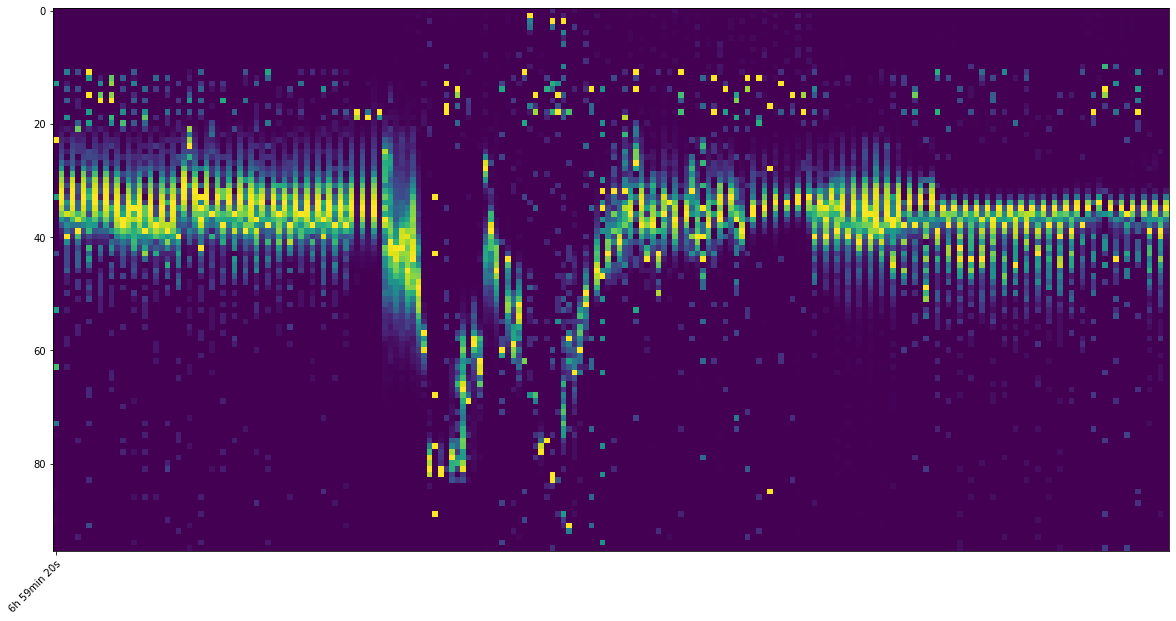

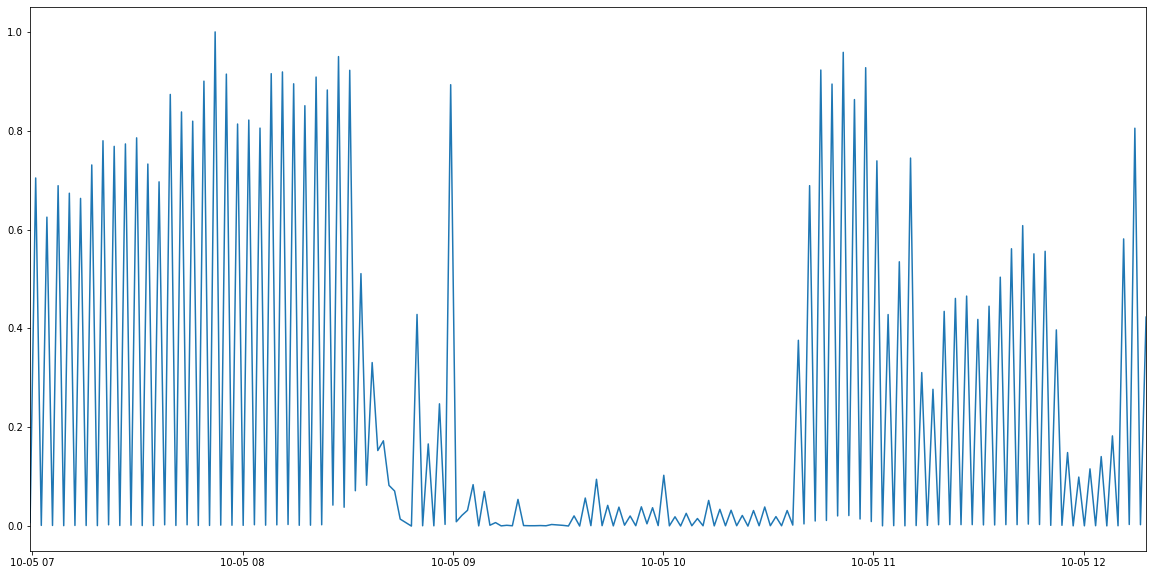

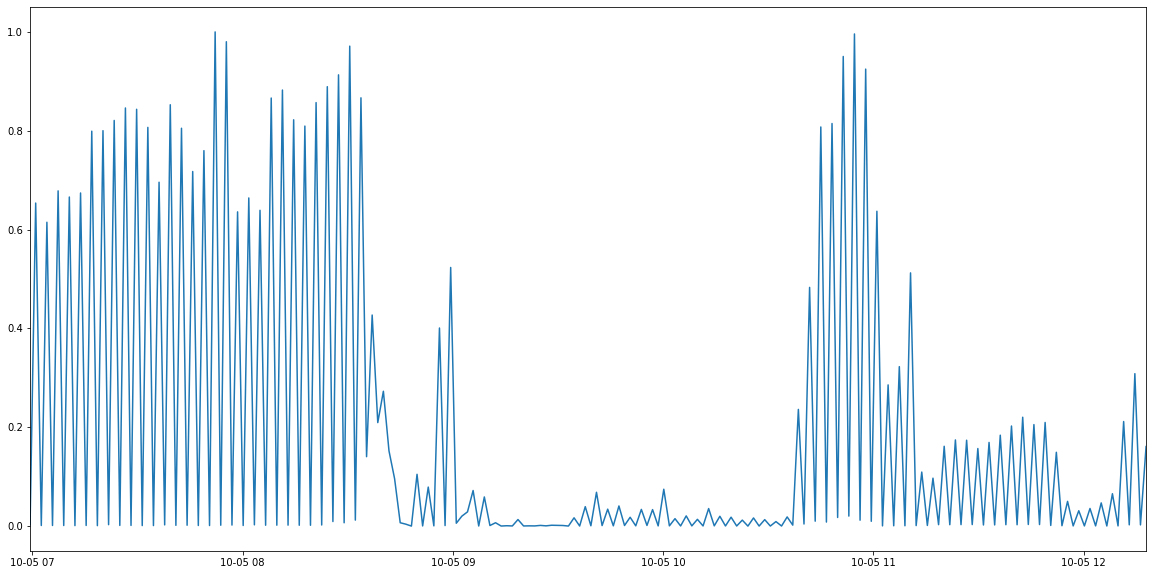

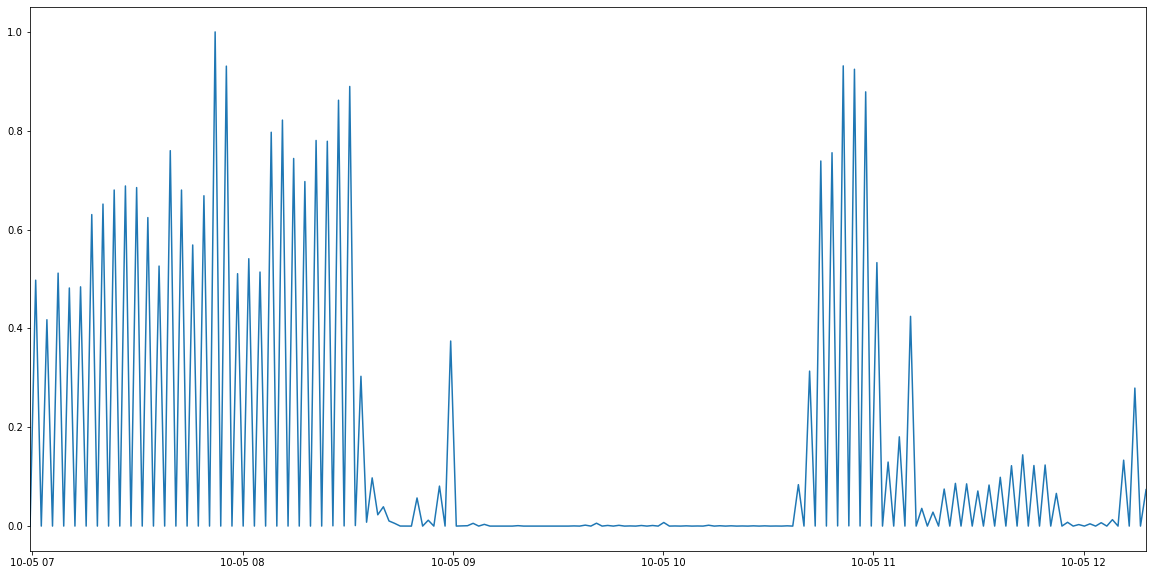

PART 1


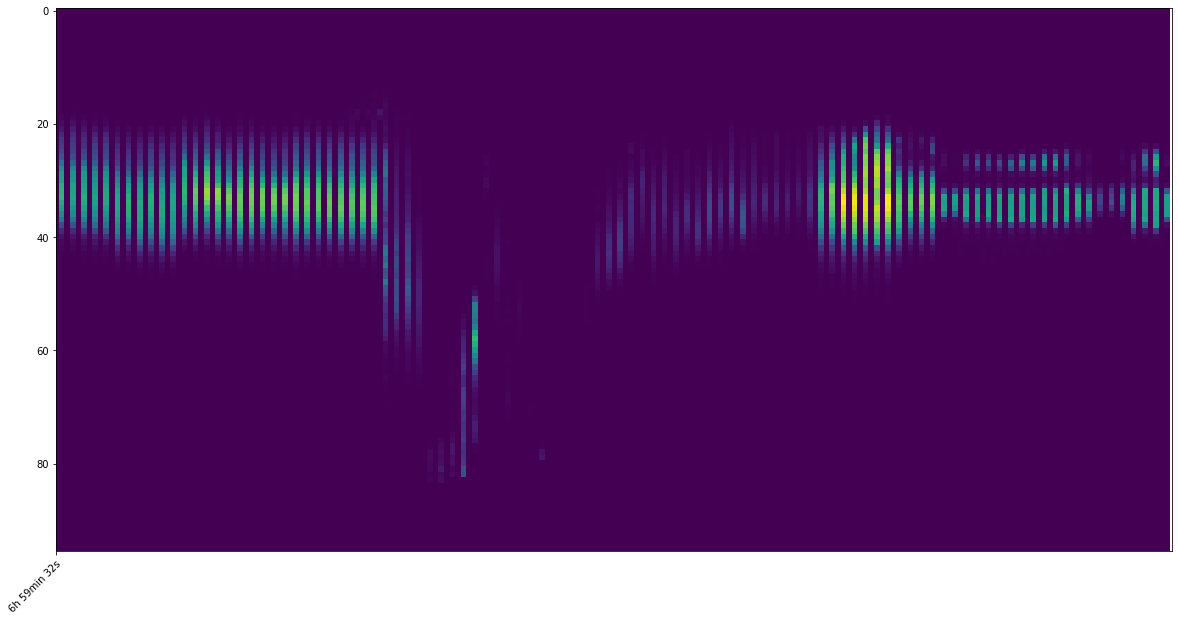

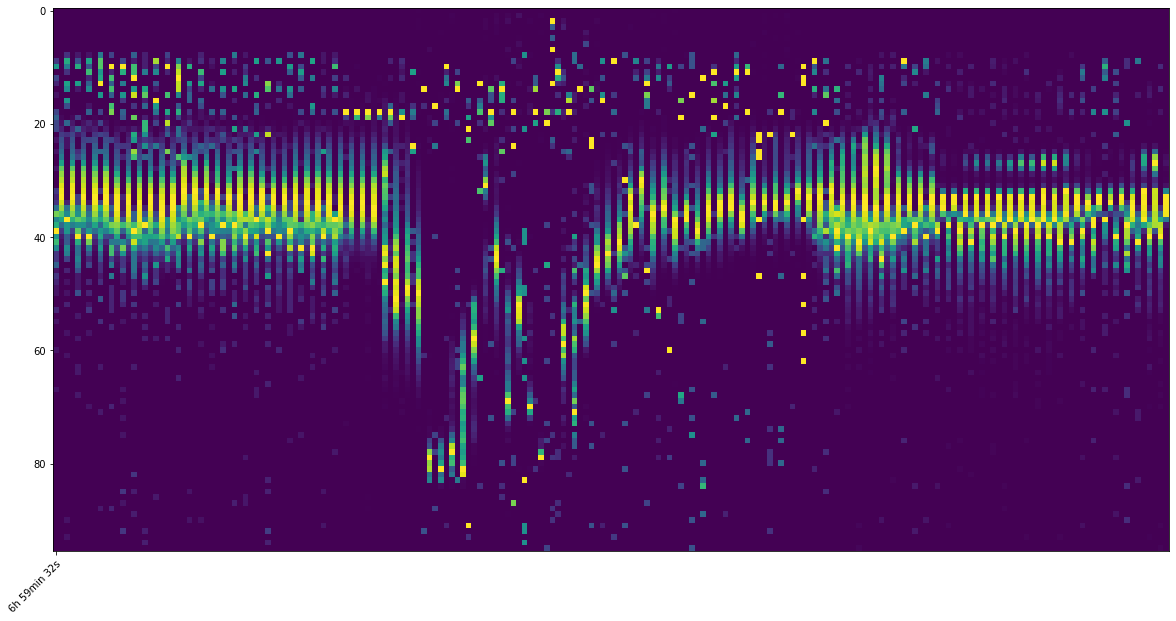

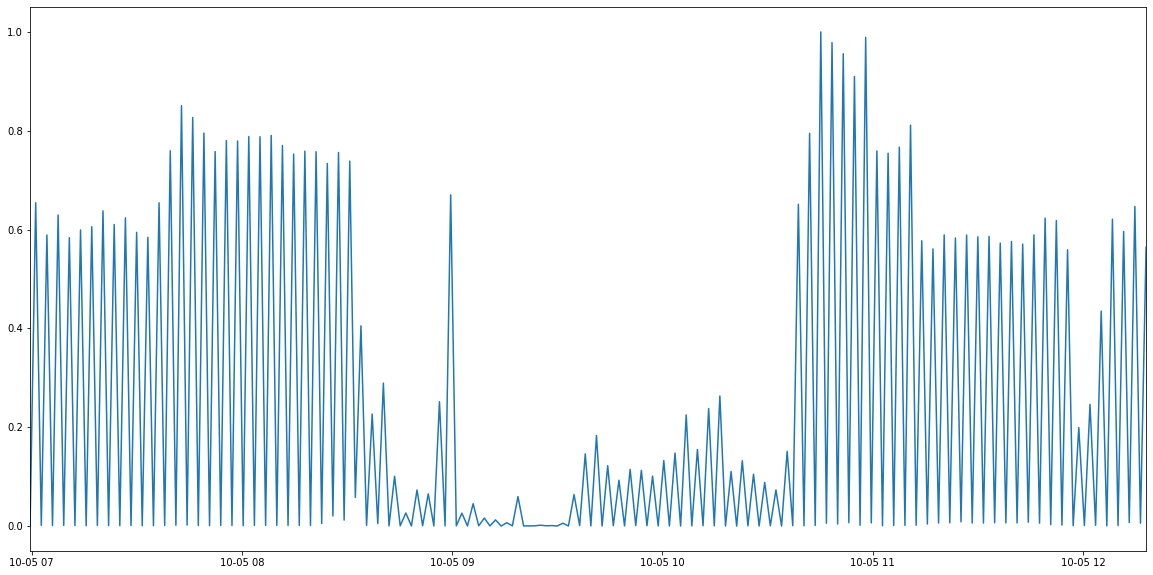

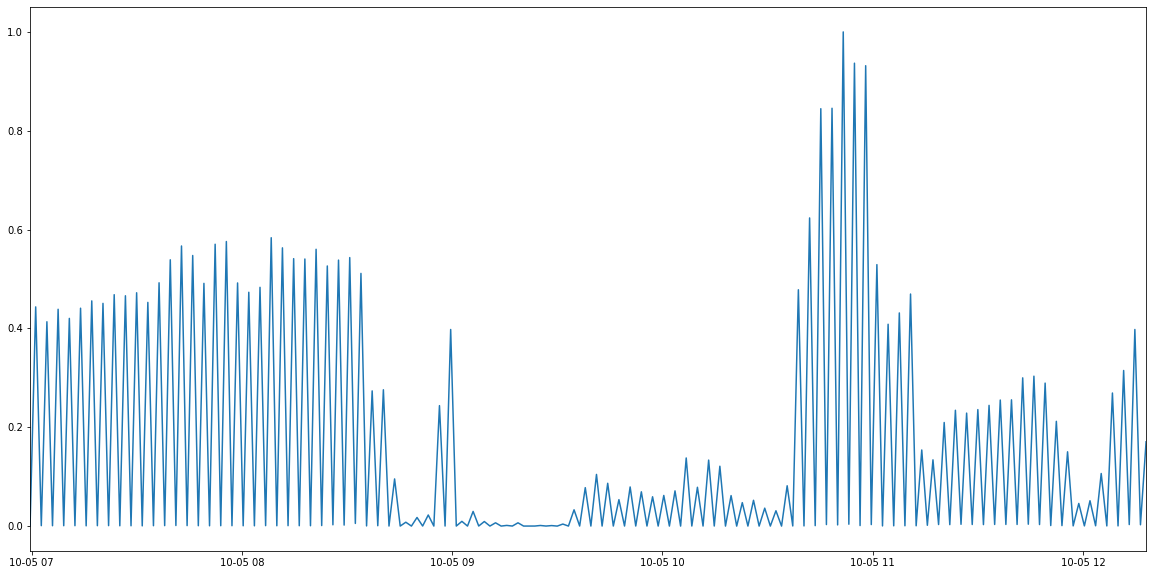

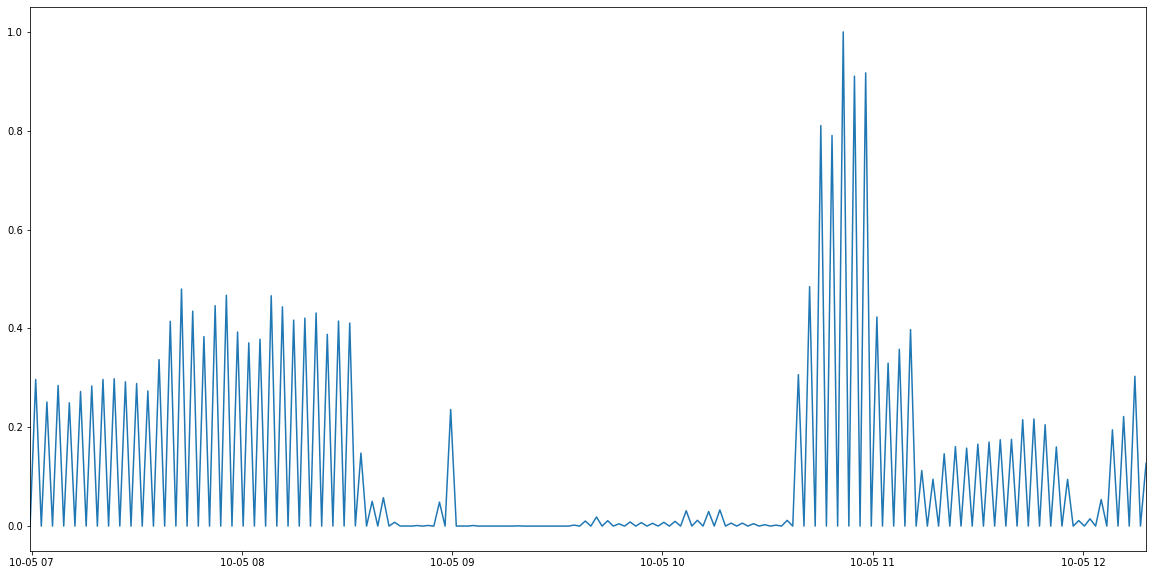

PART 2


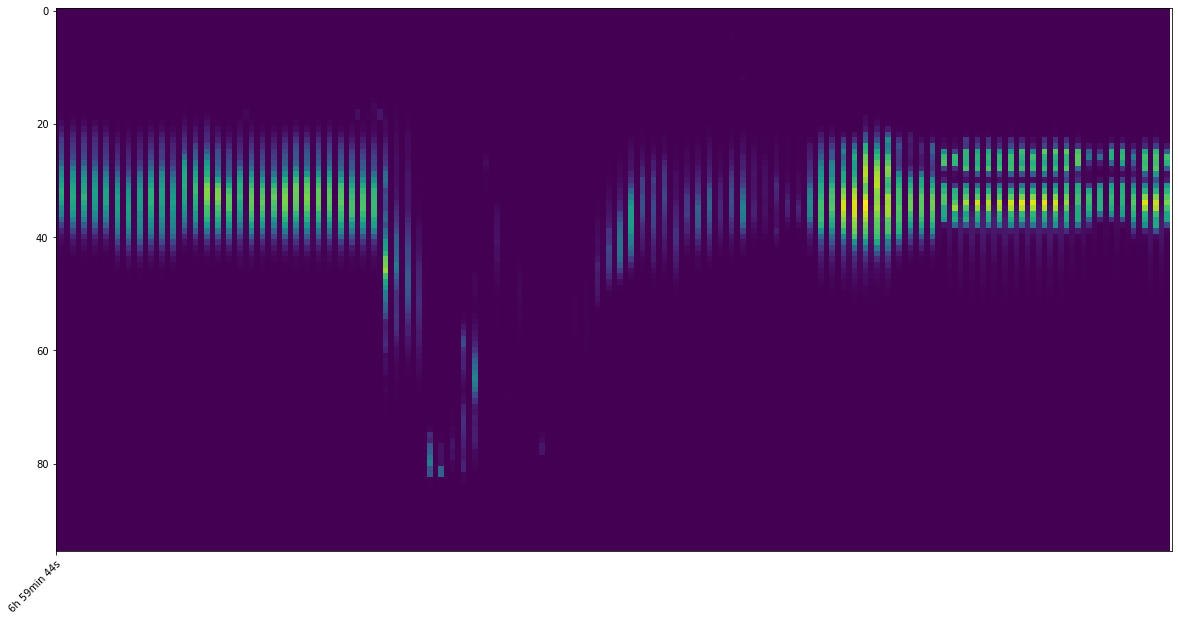

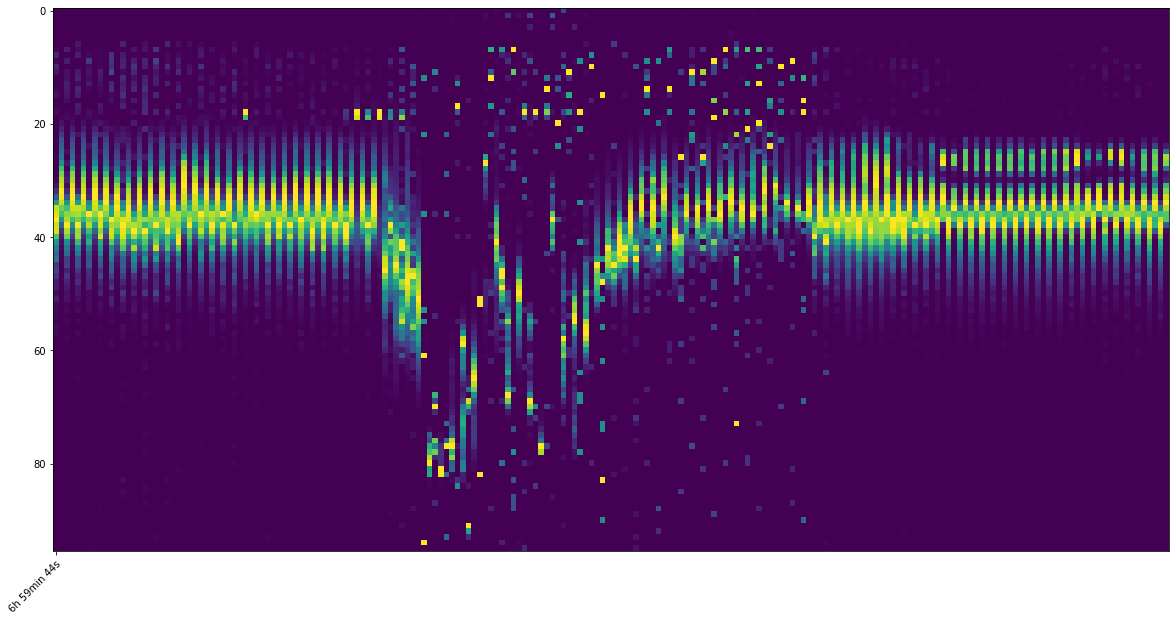

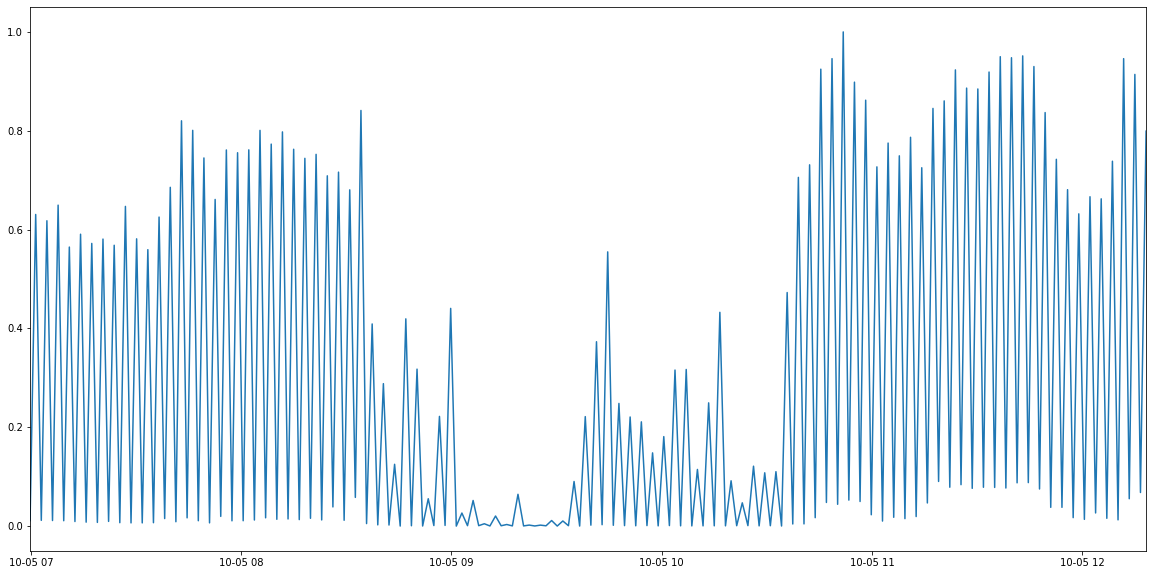

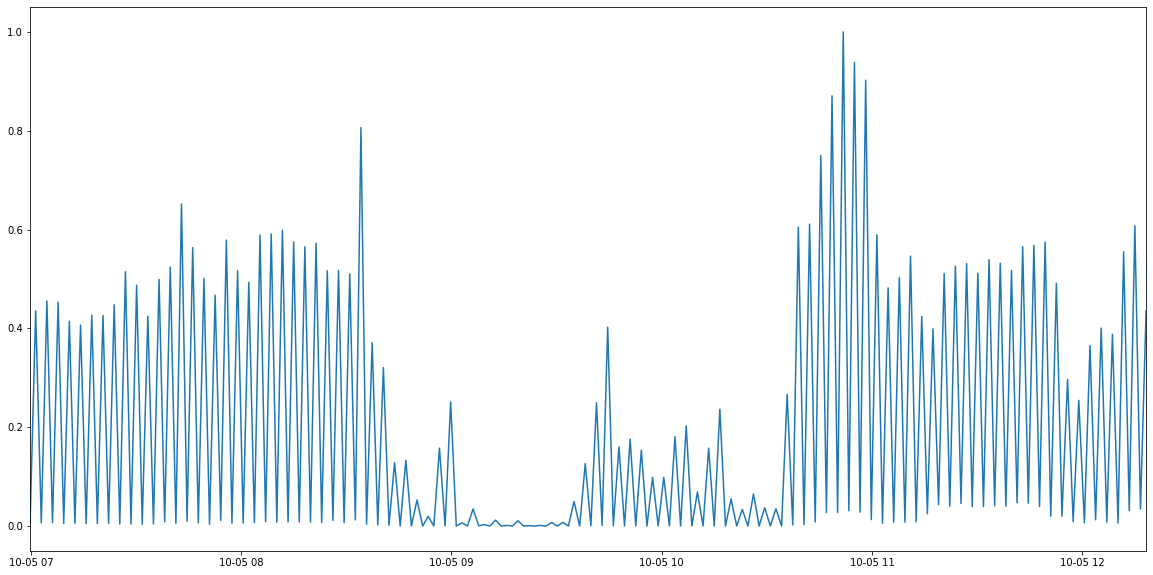

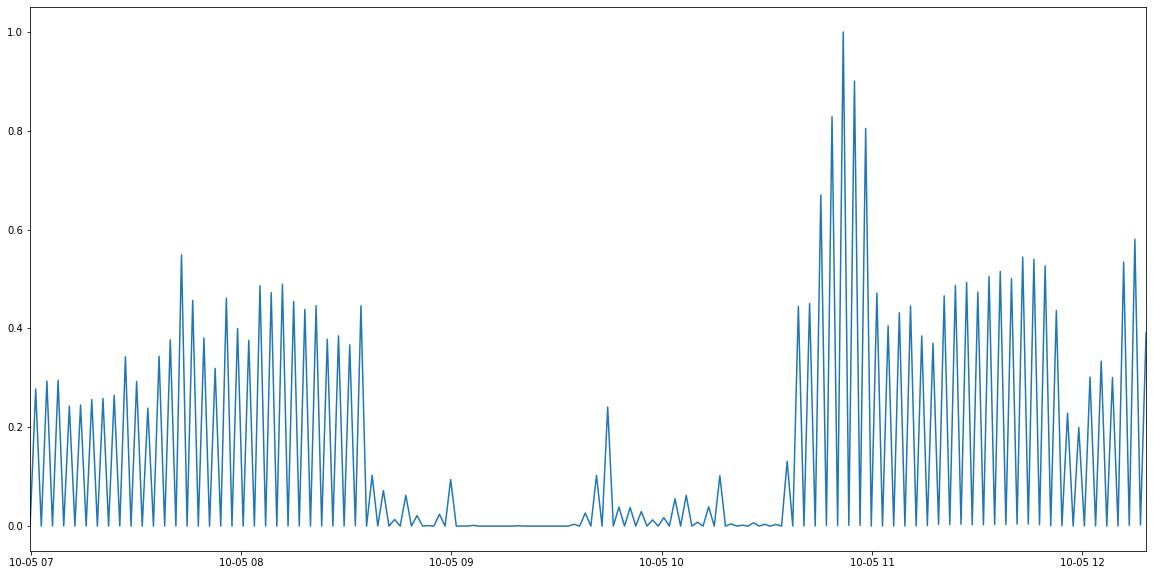

PART 3


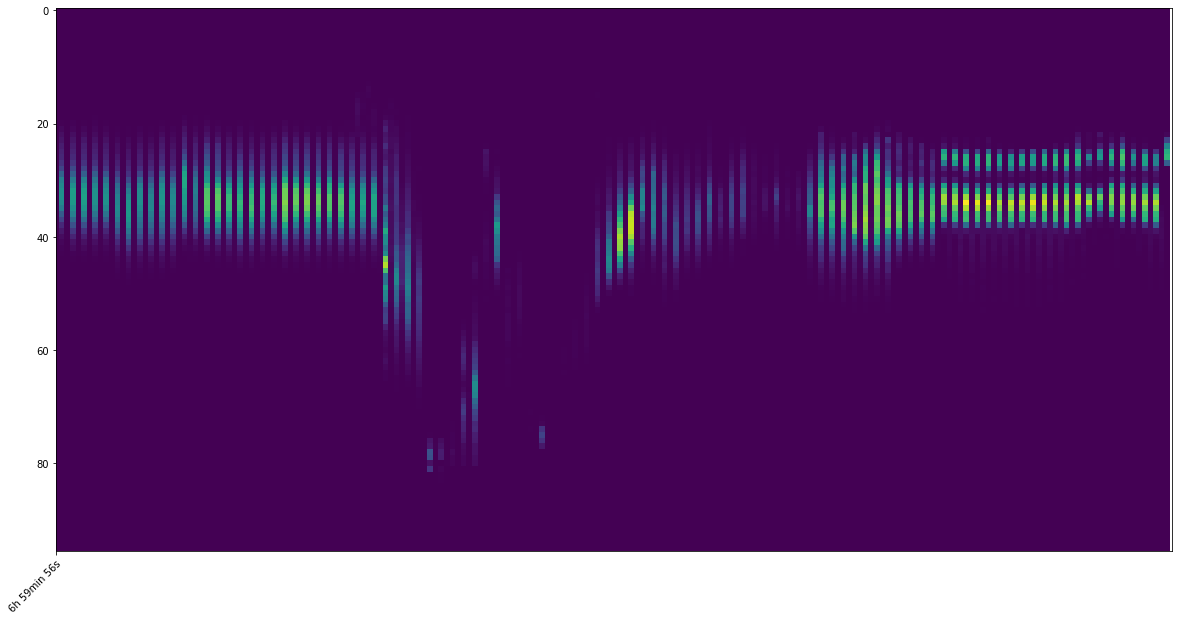

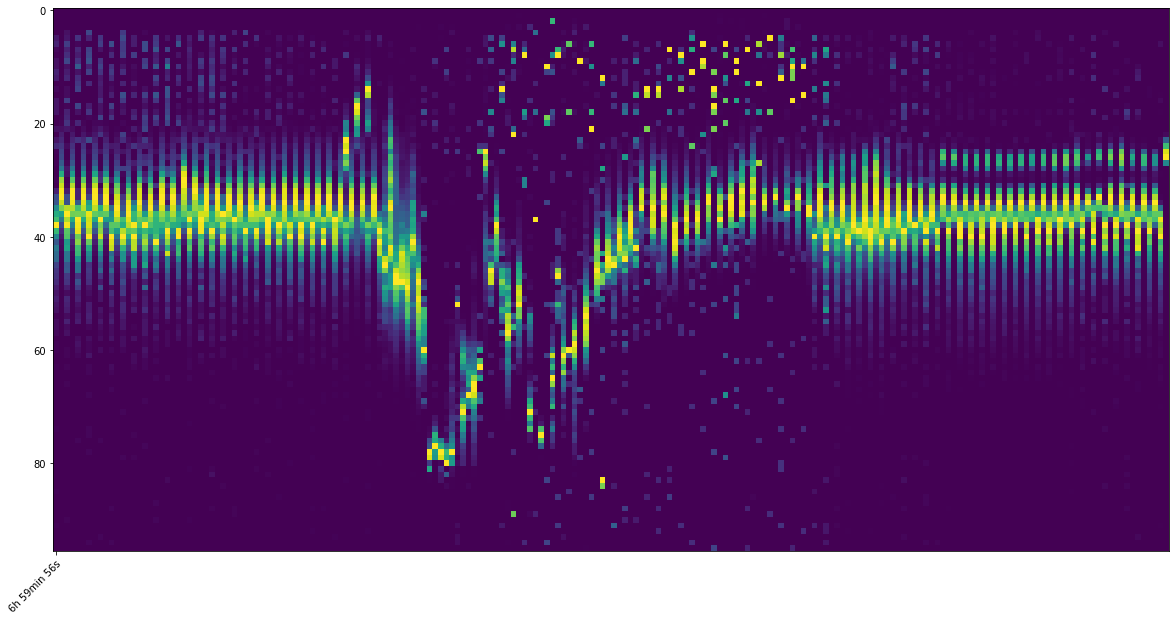

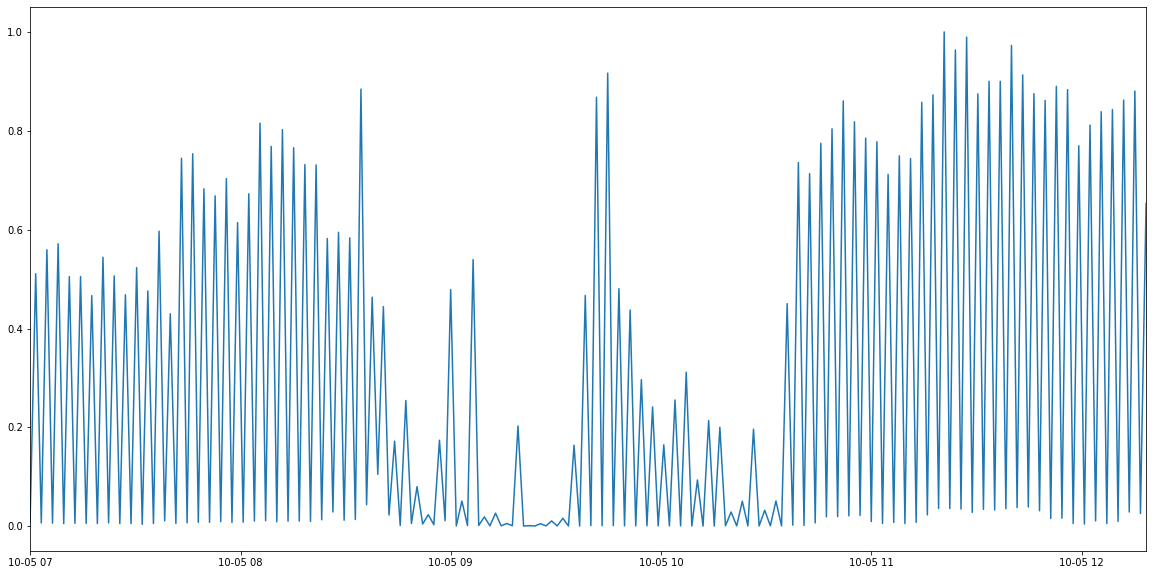

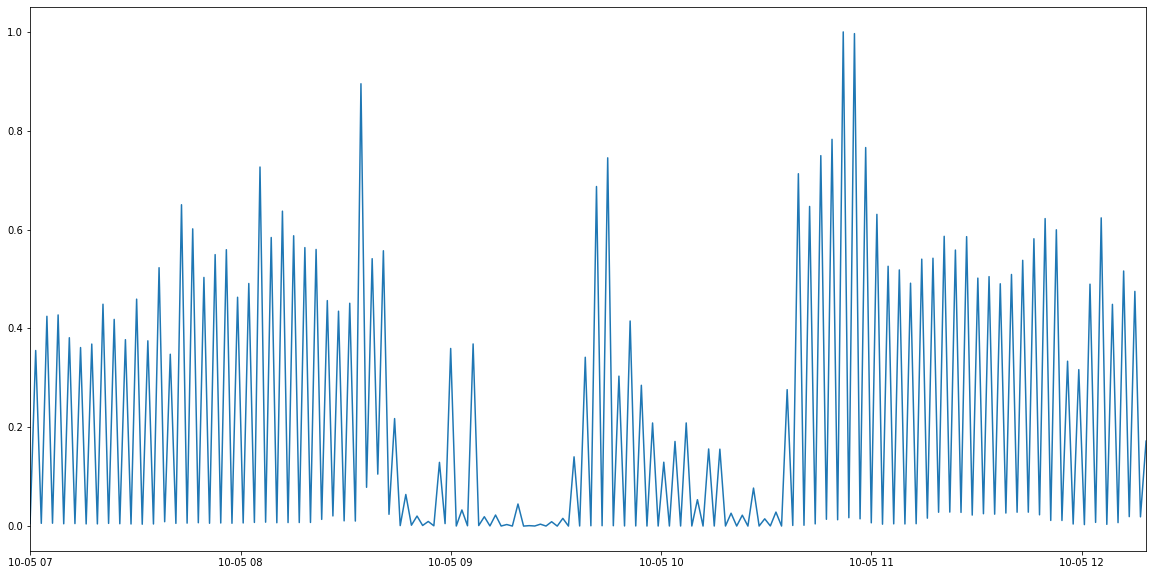

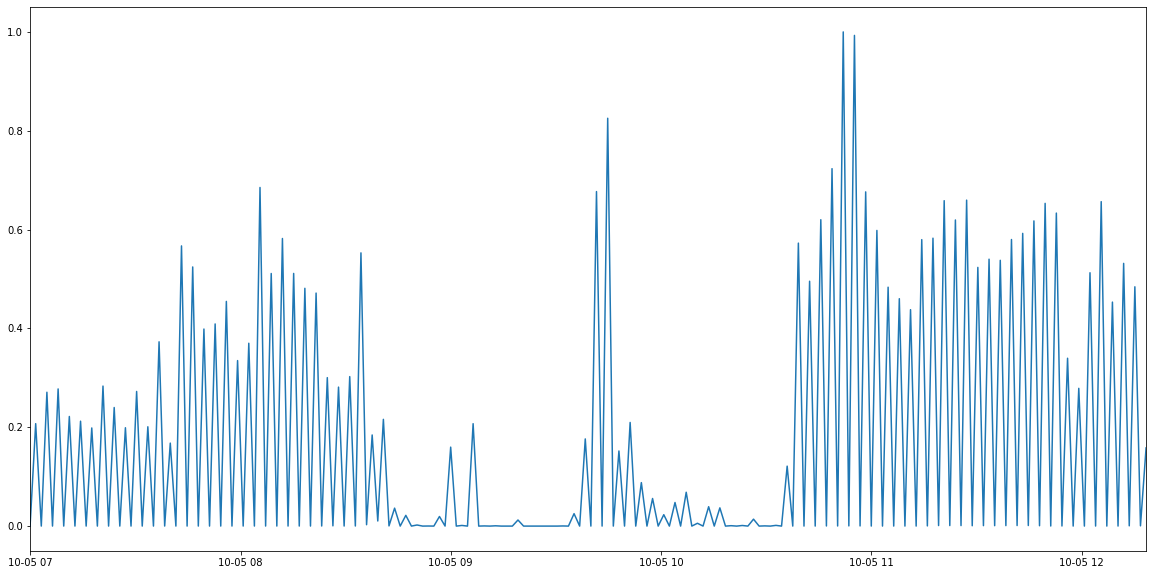

PART 4


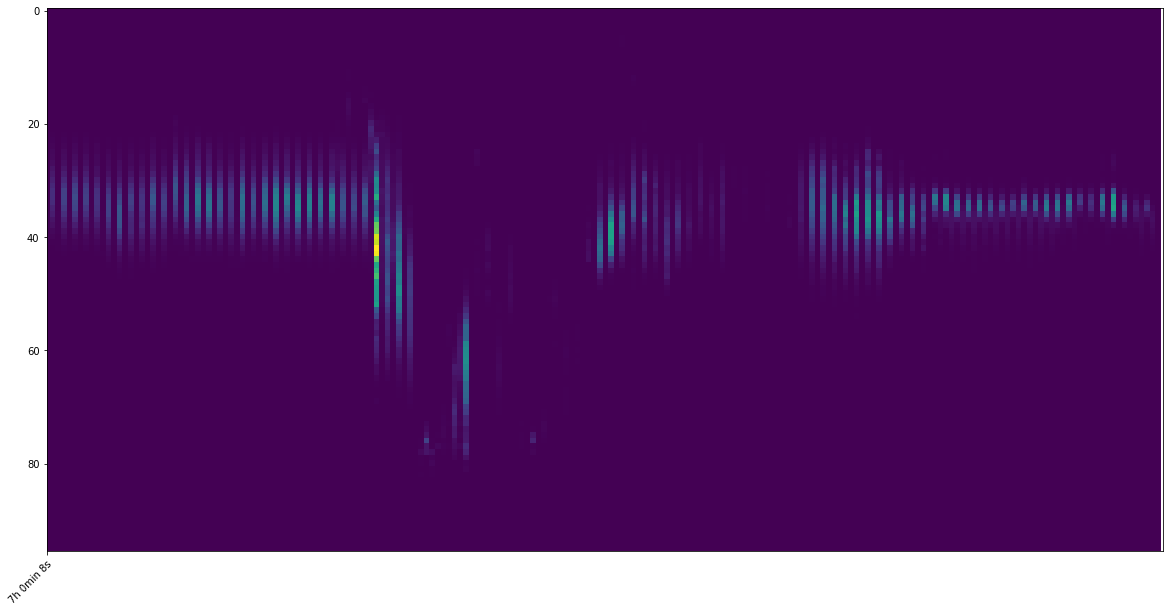

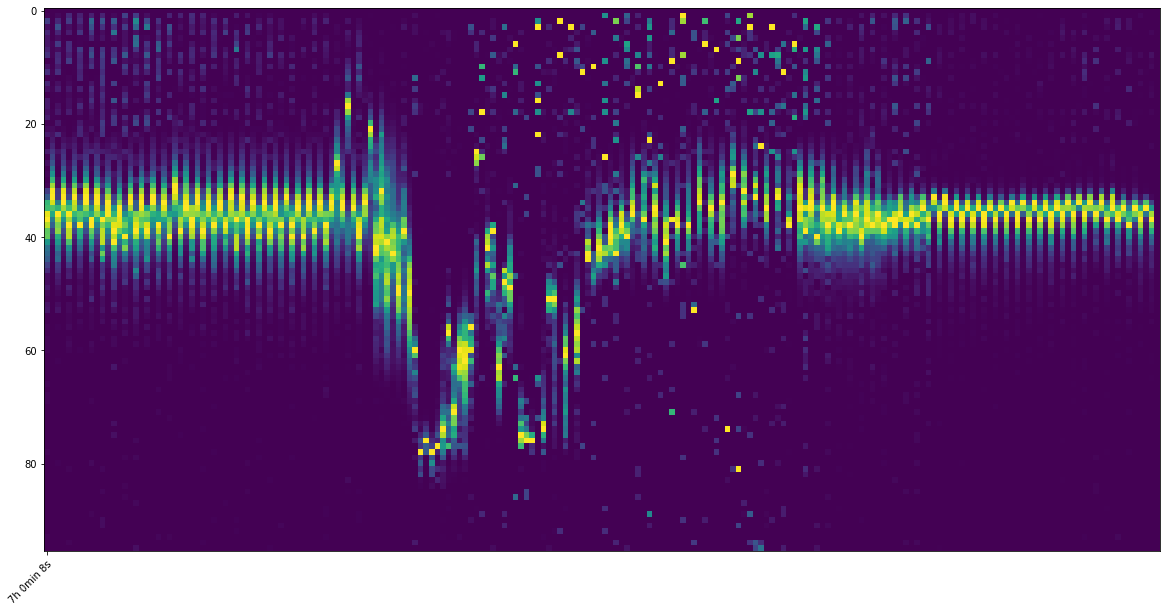

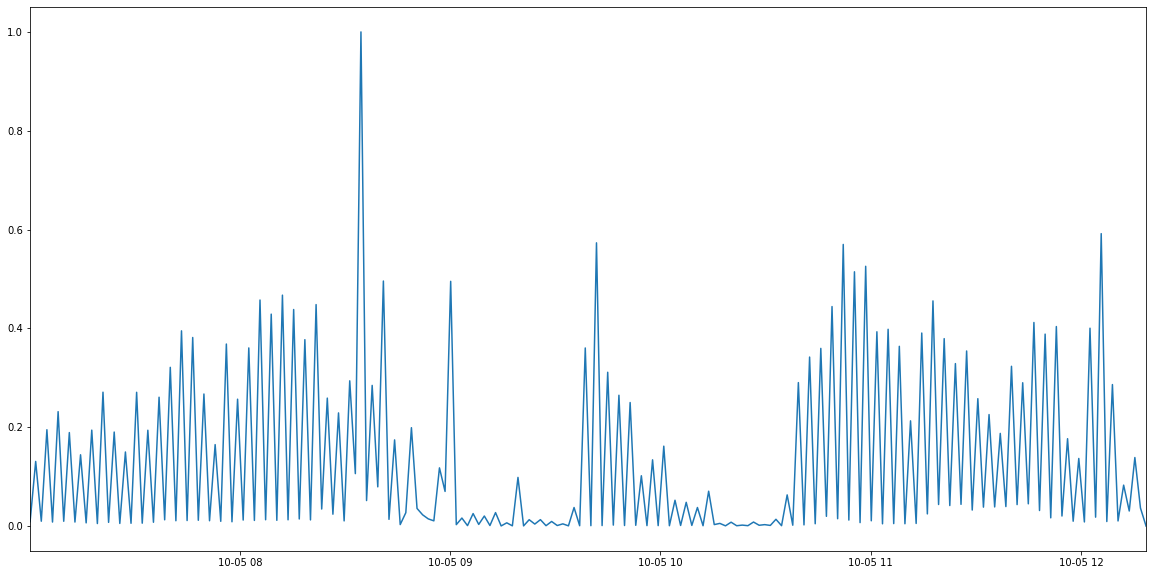

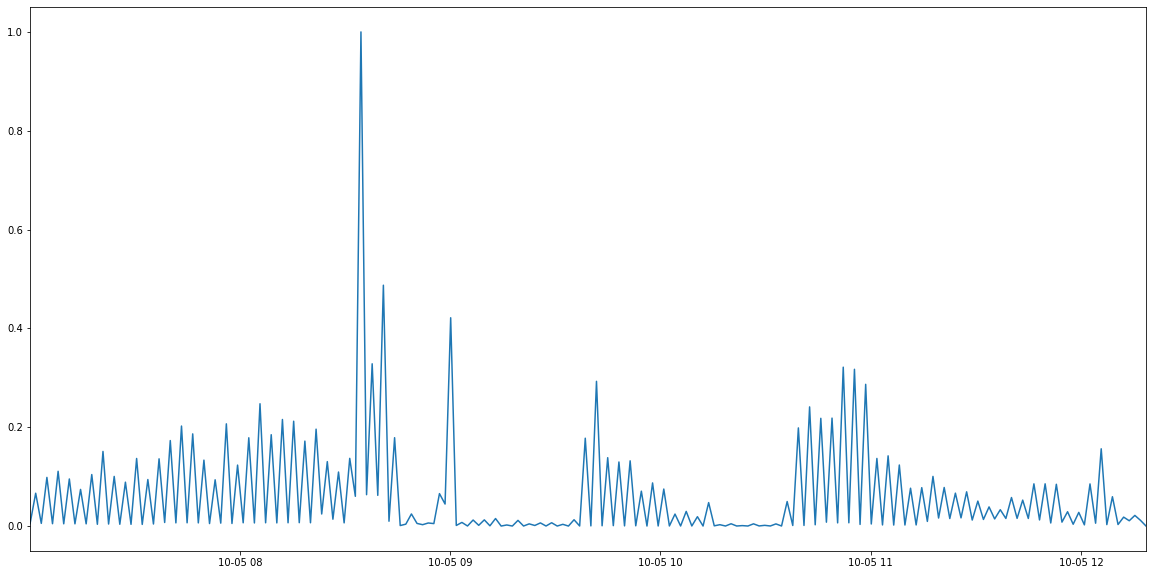

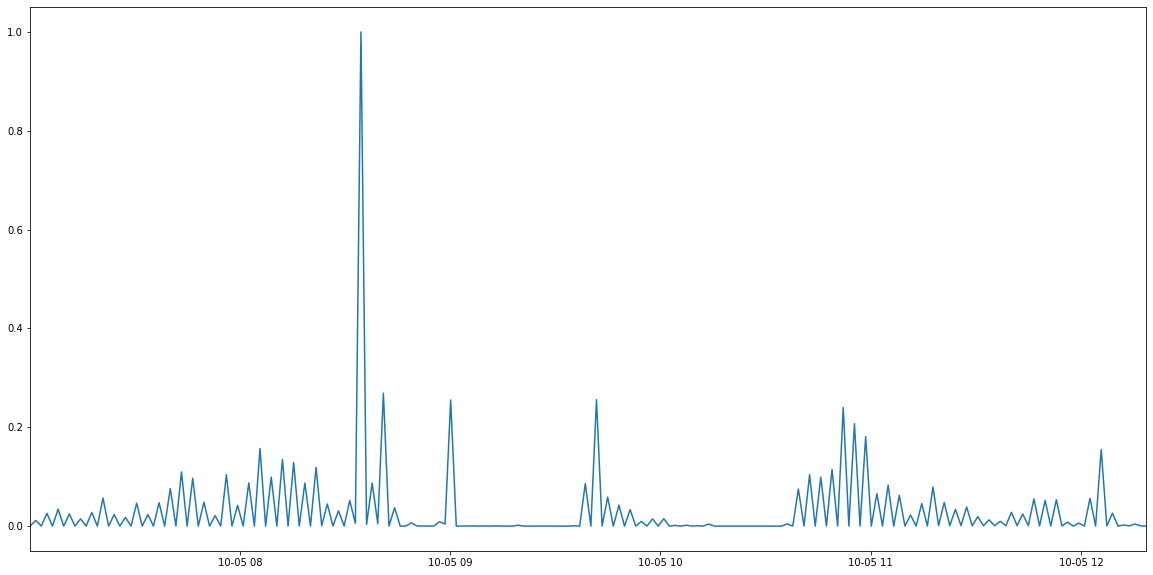

PART 5


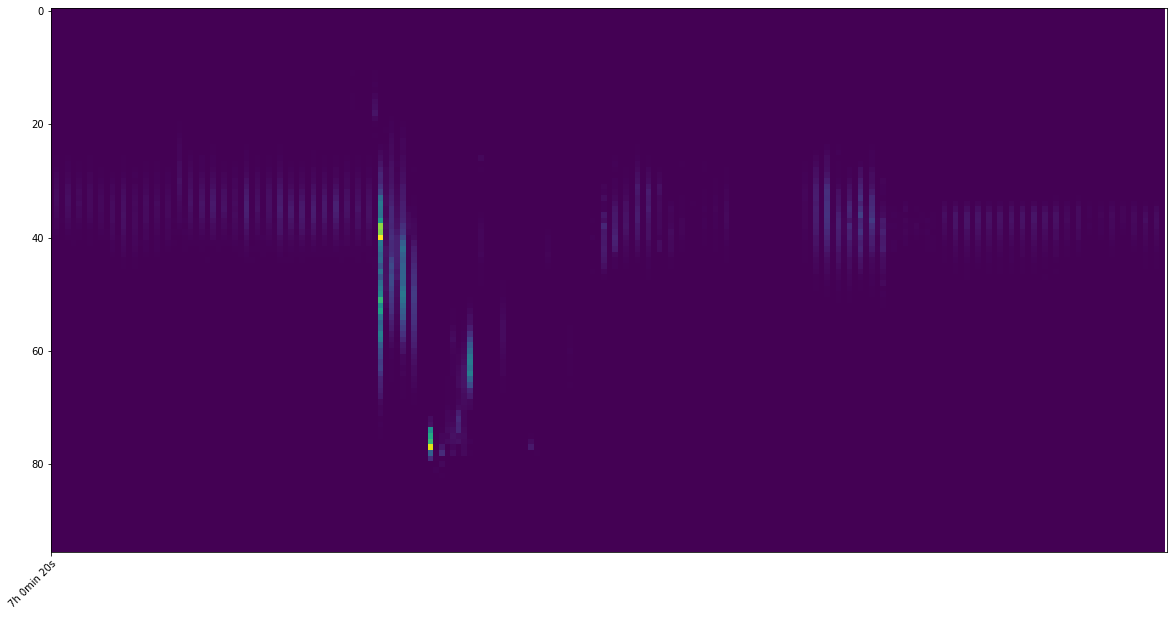

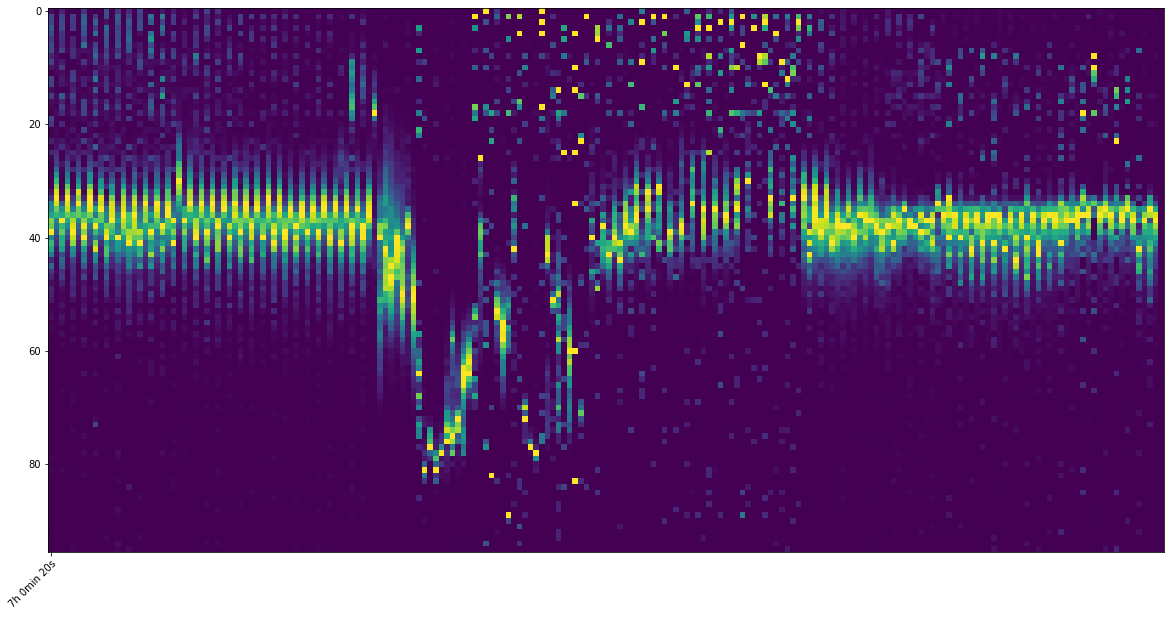

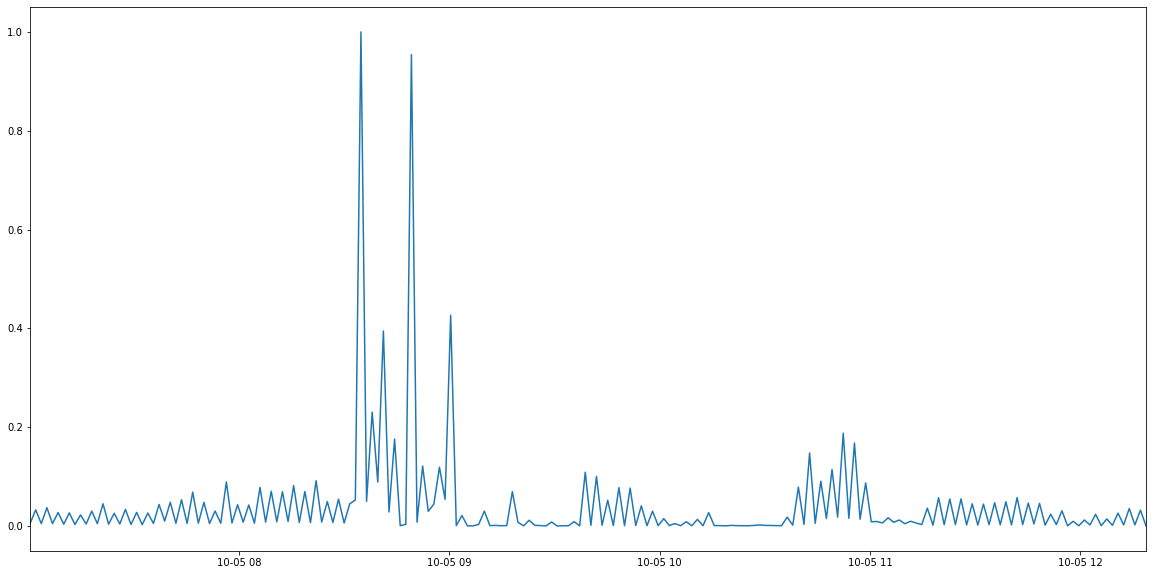

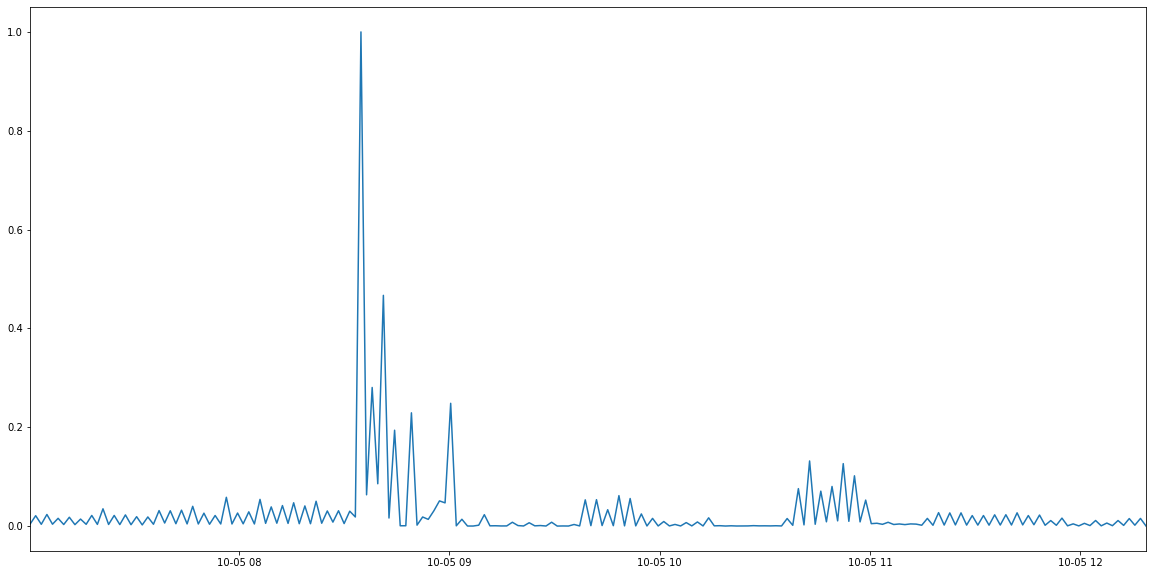

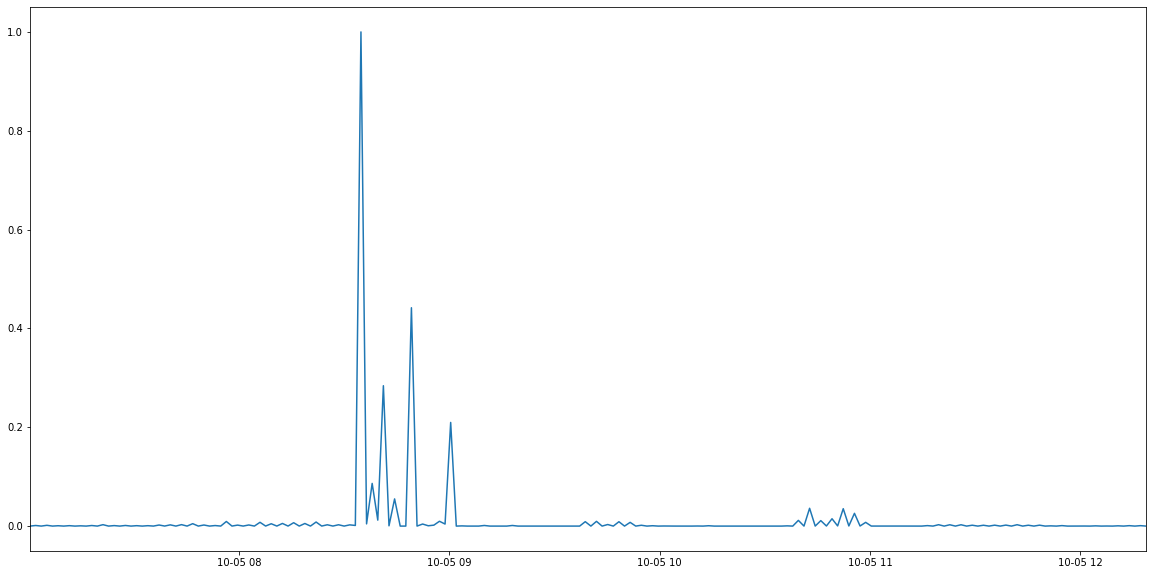

PART 6


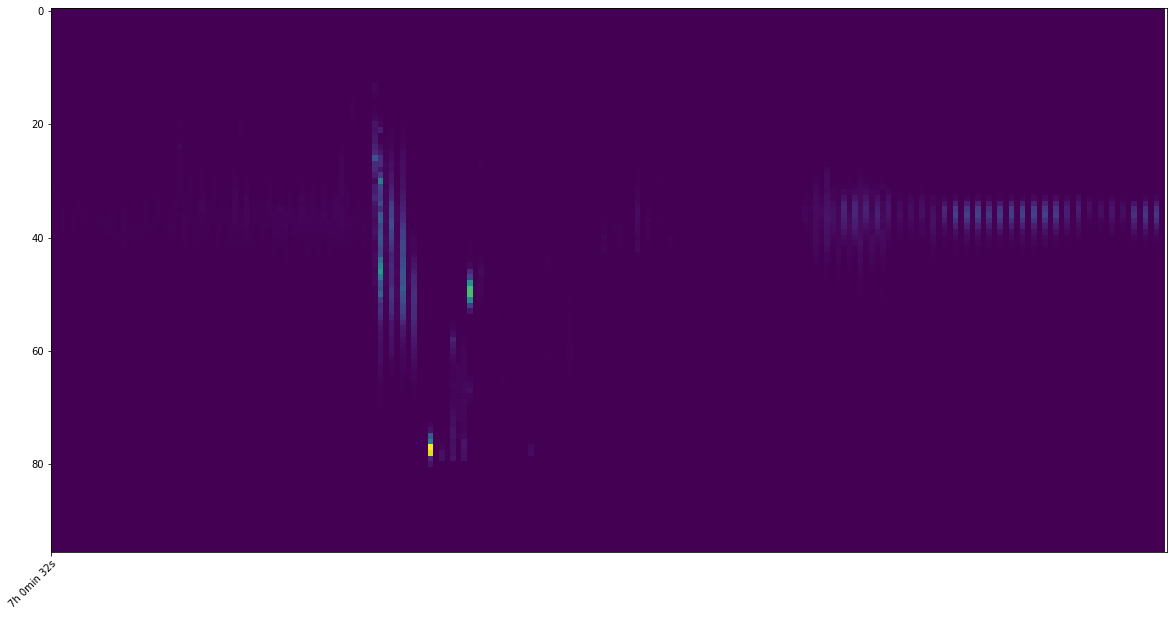

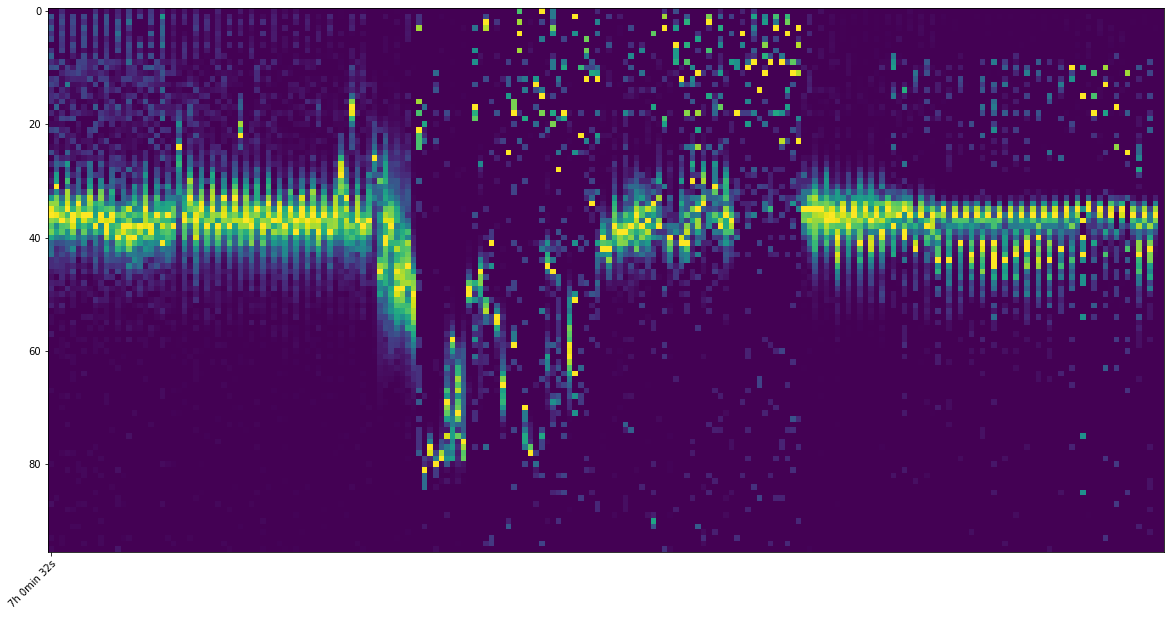

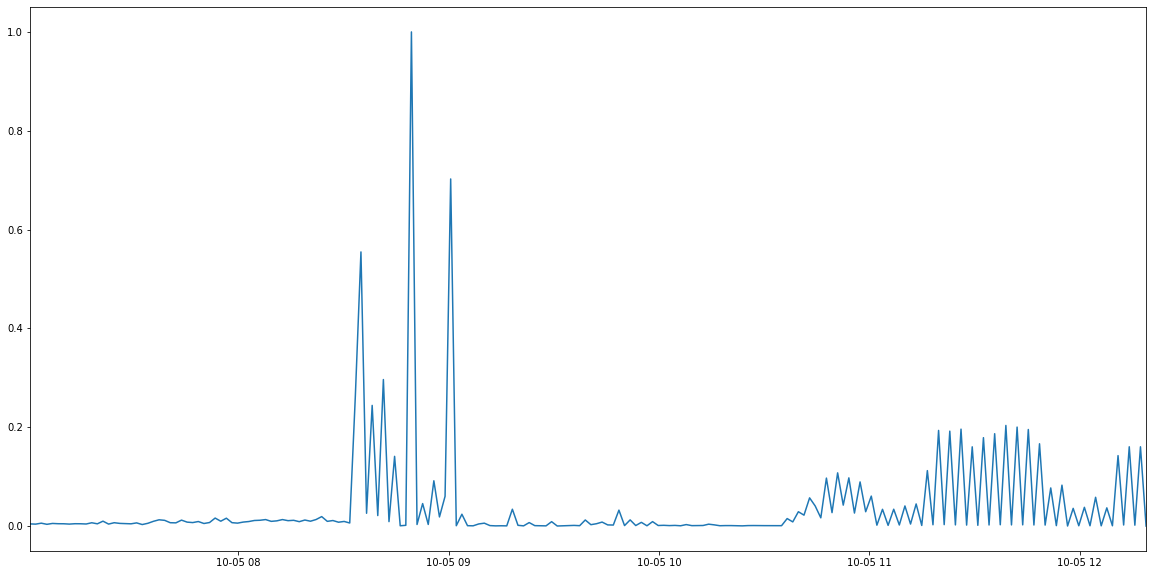

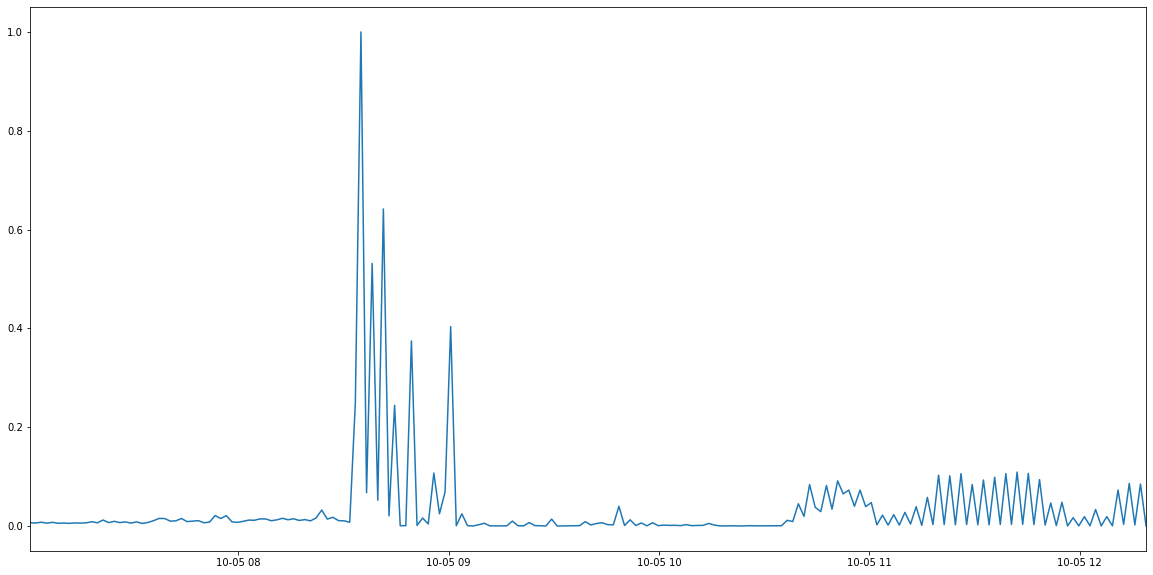

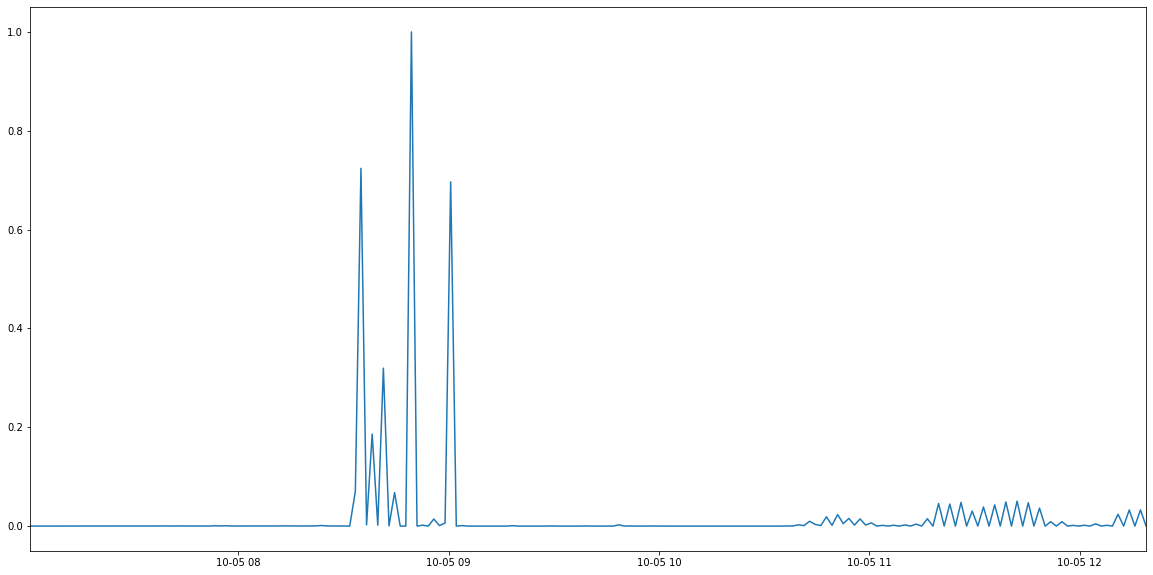

PART 7


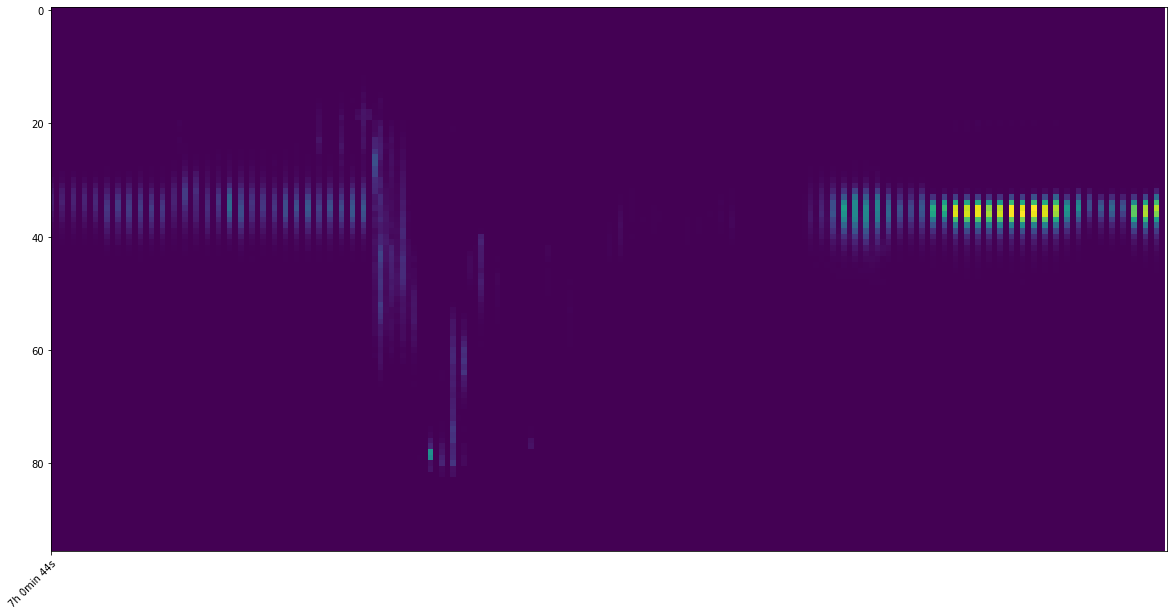

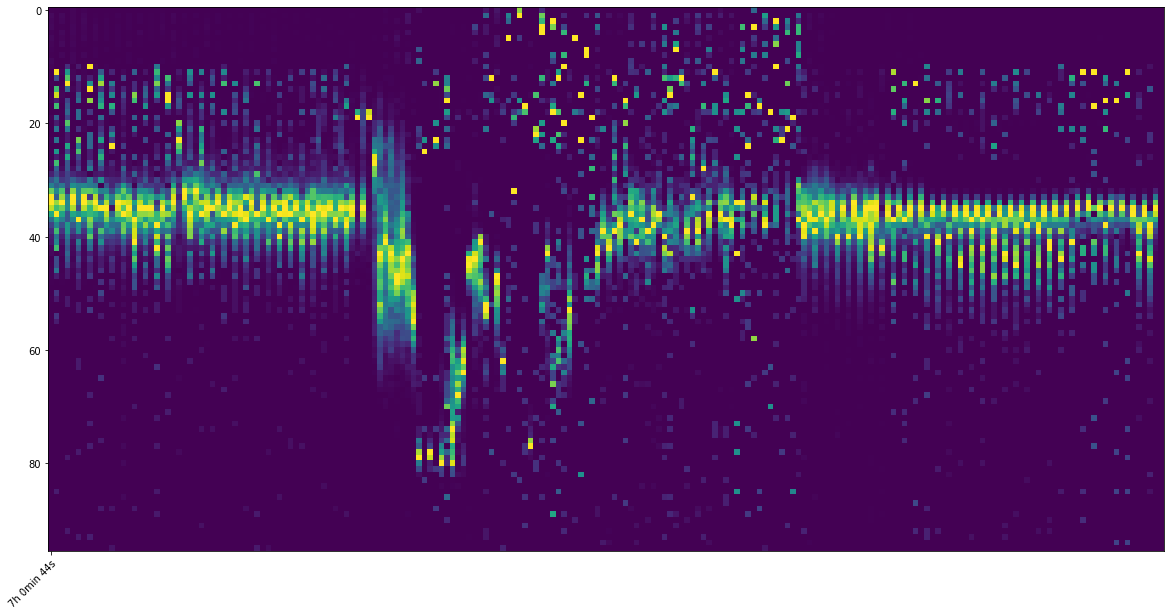

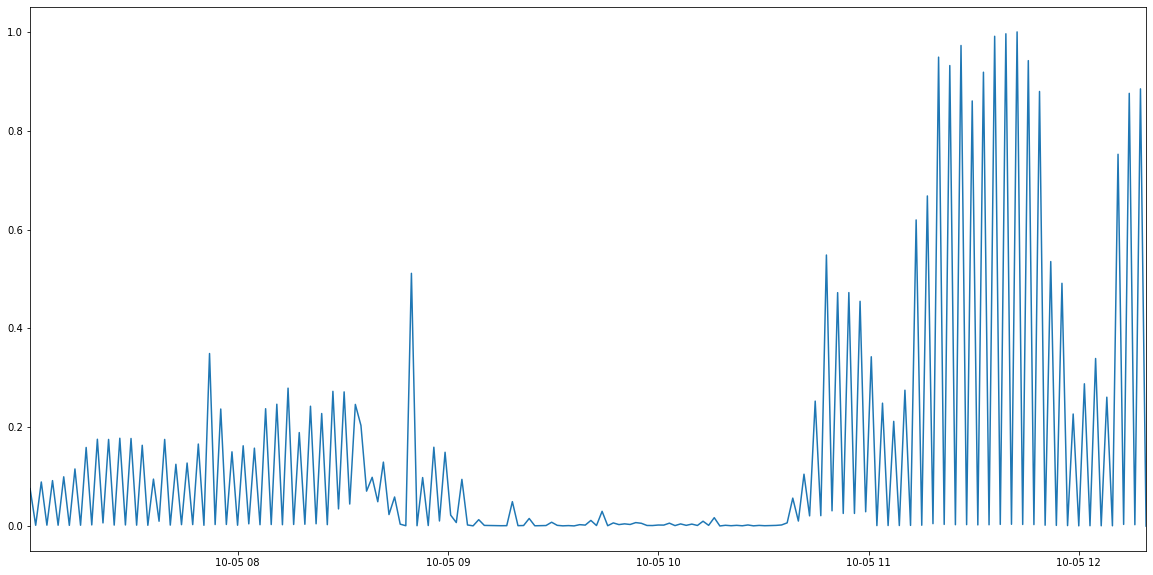

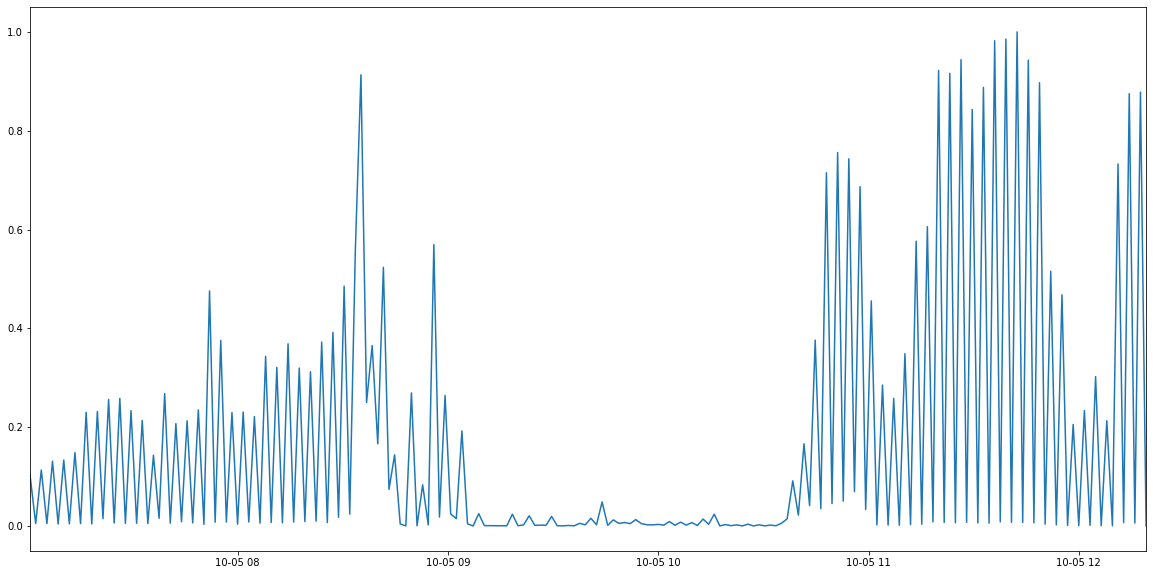

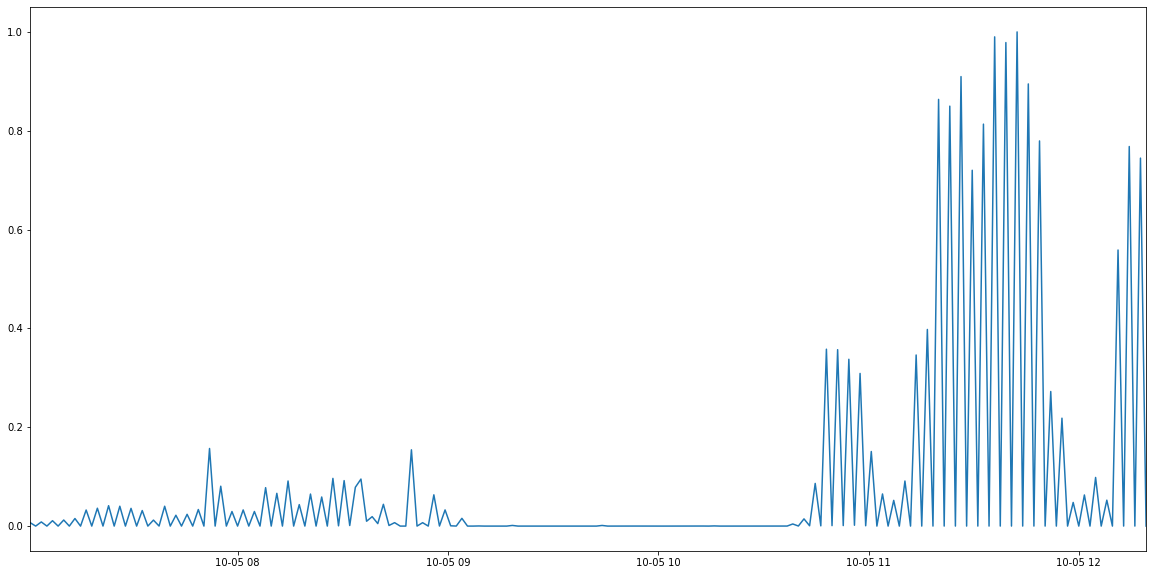

In [1747]:
for i, part in enumerate(sliced_combined_section):

    print("PART {}".format(i))
    image = part.T#combined_section.T
    T = image.T.index

    x = image
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    scaled_image = pandas.DataFrame(x_scaled)


    fig, ax = plt.subplots(figsize=(20,10))
    im = ax.imshow(image, interpolation='nearest', aspect='auto')
    ticks = np.round((60*60)/sample_rate.seconds).astype(int)
    ax.set_xticks(np.arange(0, len(T), ticks))
    ax.set_xticklabels(["{}h {}min {}s".format(Y.hour, Y.minute, Y.second) for Y in T[np.arange(0, len(T), ticks)]])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    plt.xlim([0, len(T)])
    plt.show()

    fig, ax = plt.subplots(figsize=(20,10))
    im = ax.imshow(scaled_image, interpolation='nearest', aspect='auto')
    ticks = np.round((60*60)/sample_rate.seconds).astype(int)
    ax.set_xticks(np.arange(0, len(T), ticks))
    ax.set_xticklabels(["{}h {}min {}s".format(Y.hour, Y.minute, Y.second) for Y in T[np.arange(0, len(T), ticks)]])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    plt.show()
    
    plt.figure(figsize=(20,10))
    trace = image.max()
    plt.plot(trace/trace.max())
    plt.xlim([T[0], T[len(T)-1]])
    plt.show()

    plt.figure(figsize=(20,10))
    trace = image.mean()
    plt.plot(trace/trace.max())
    plt.xlim([T[0], T[len(T)-1]])
    plt.show()

    plt.figure(figsize=(20,10))
    trace = image.var()
    plt.plot(trace/trace.max())
    plt.xlim([T[0], T[len(T)-1]])
    plt.show()

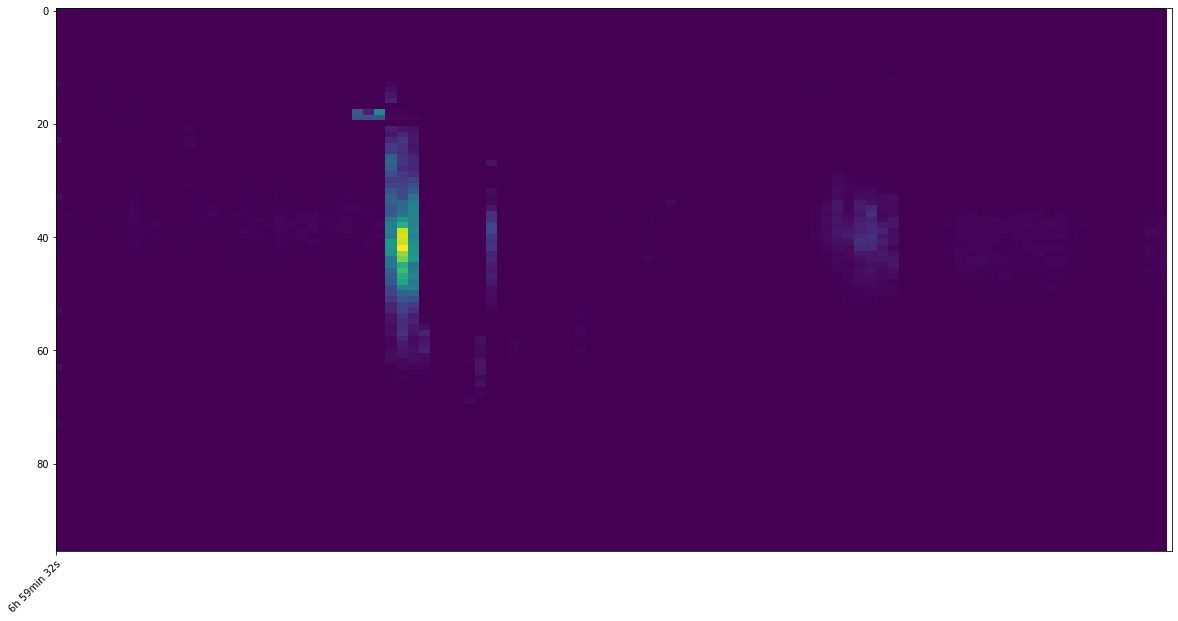

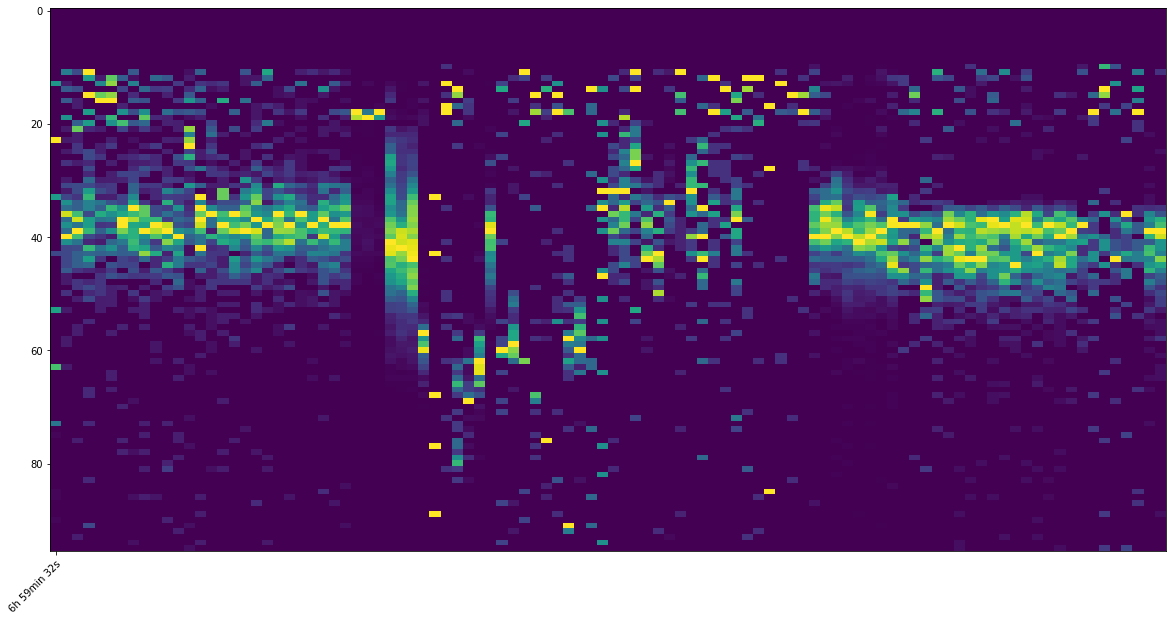

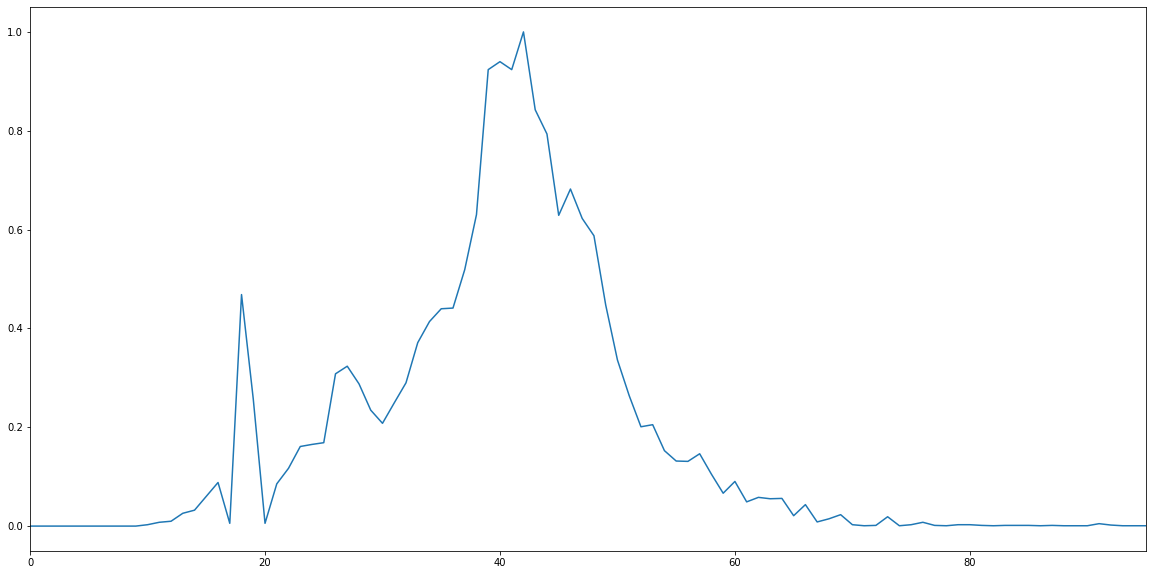

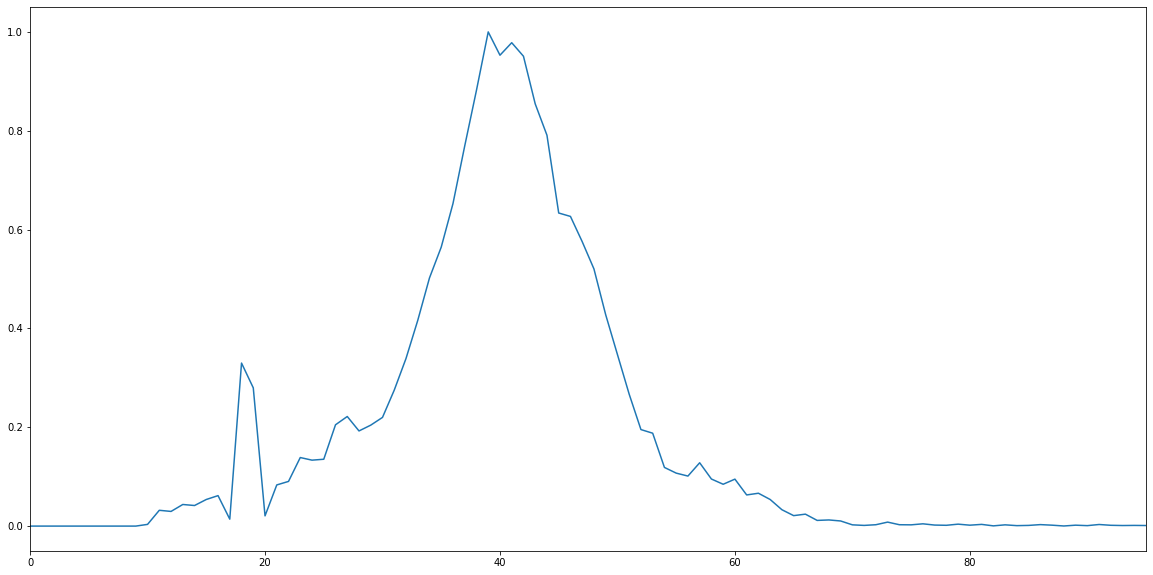

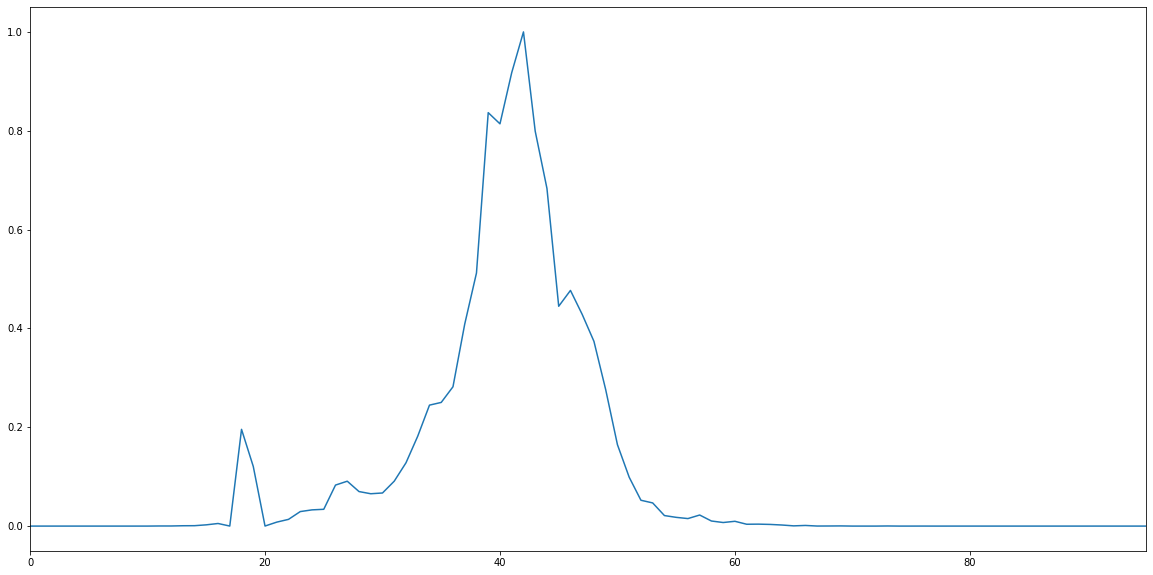

In [1734]:
index = sliced_combined_section[1].index

data = (
    
sliced_combined_section[0].values +  #
sliced_combined_section[1].values +   #
sliced_combined_section[2].values +
sliced_combined_section[3].values +
sliced_combined_section[4].values +
sliced_combined_section[5].values +
sliced_combined_section[6].values +
sliced_combined_section[7].values +
sliced_combined_section[8].values +
sliced_combined_section[9].values +
sliced_combined_section[10].values + #   
sliced_combined_section[11].values +
sliced_combined_section[12].values +
sliced_combined_section[13].values +
sliced_combined_section[14].values +
sliced_combined_section[15].values 
)


image = data.T
T = index

x = image
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled_image = pandas.DataFrame(x_scaled)


fig, ax = plt.subplots(figsize=(20,10))
im = ax.imshow(image, interpolation='nearest', aspect='auto')
ticks = np.round((60*60)/sample_rate.seconds).astype(int)
ax.set_xticks(np.arange(0, len(T), ticks))
ax.set_xticklabels(["{}h {}min {}s".format(Y.hour, Y.minute, Y.second) for Y in T[np.arange(0, len(T), ticks)]])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.xlim([0, len(T)])
plt.show()

fig, ax = plt.subplots(figsize=(20,10))
im = ax.imshow(scaled_image, interpolation='nearest', aspect='auto')
ticks = np.round((60*60)/sample_rate.seconds).astype(int)
ax.set_xticks(np.arange(0, len(T), ticks))
ax.set_xticklabels(["{}h {}min {}s".format(Y.hour, Y.minute, Y.second) for Y in T[np.arange(0, len(T), ticks)]])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.show()

plt.figure(figsize=(20,10))
trace = [i.max() for i in image]
plt.plot(trace/np.max(trace))
plt.xlim([0, len(trace)-1])
plt.show()

plt.figure(figsize=(20,10))
trace = [i.mean() for i in image]
plt.plot(trace/np.max(trace))
plt.xlim([0, len(trace)-1])
plt.show()

plt.figure(figsize=(20,10))
trace = [i.var() for i in image]
plt.plot(trace/np.max(trace))
plt.xlim([0, len(trace)-1])
plt.show()



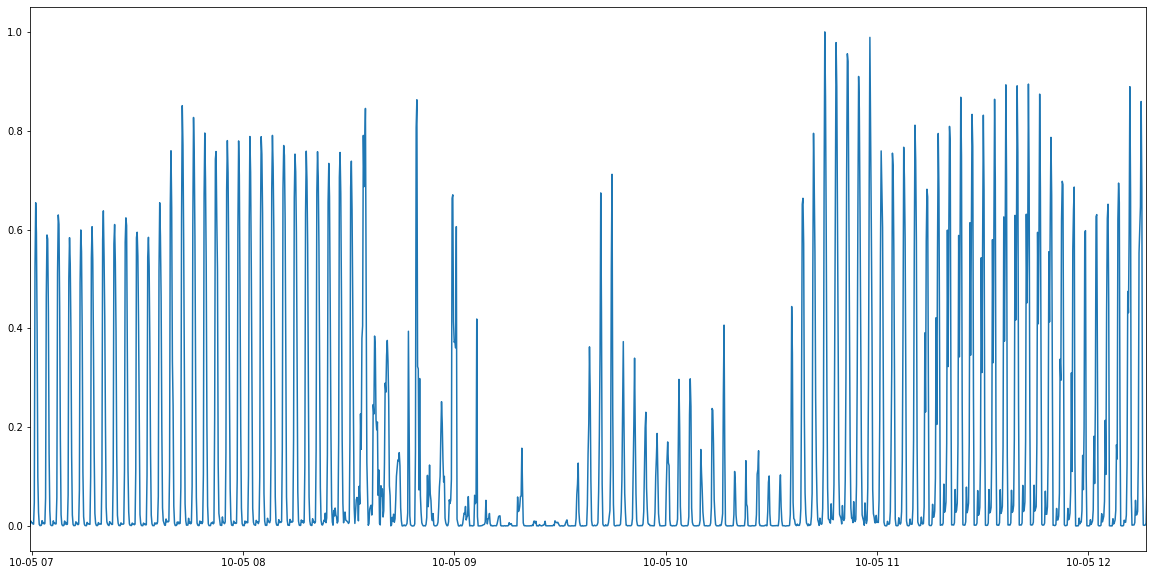

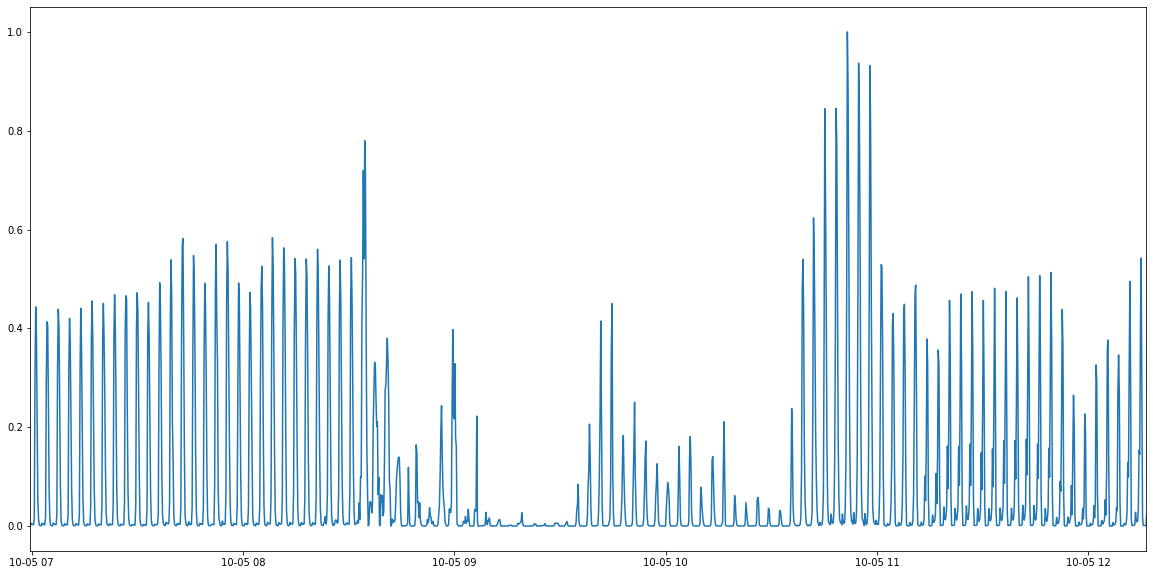

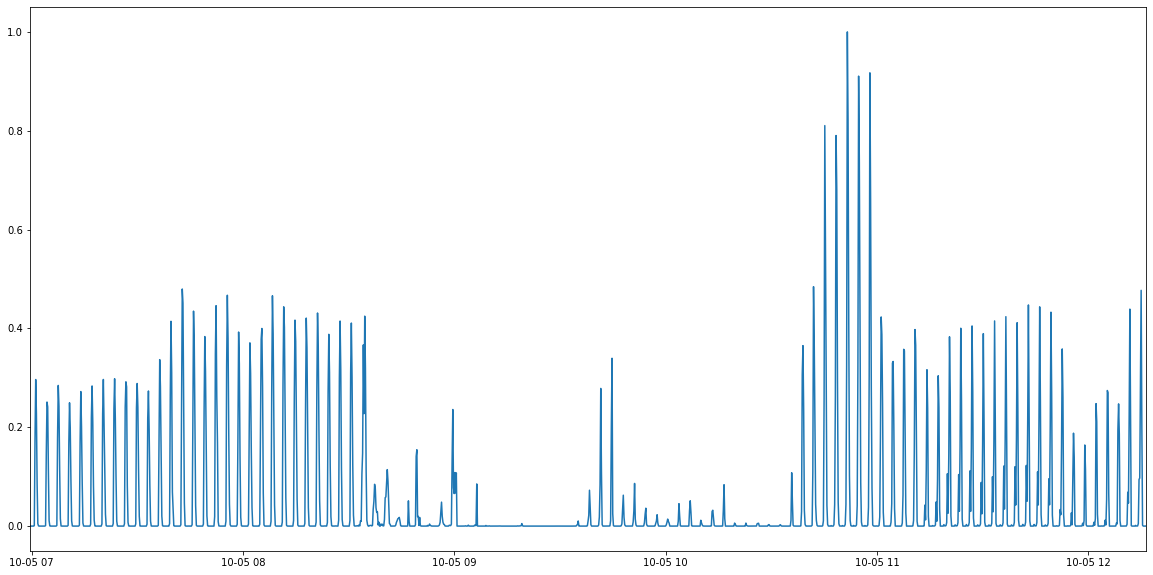

In [1712]:
image = combined_section.T

plt.figure(figsize=(20,10))
trace = image.max()
plt.plot(trace/trace.max())
plt.xlim([T[0], T[len(T)-1]])
plt.show()

plt.figure(figsize=(20,10))
trace = image.mean()
plt.plot(trace/trace.max())
plt.xlim([T[0], T[len(T)-1]])
plt.show()

plt.figure(figsize=(20,10))
trace = image.var()
plt.plot(trace/trace.max())
plt.xlim([T[0], T[len(T)-1]])
plt.show()

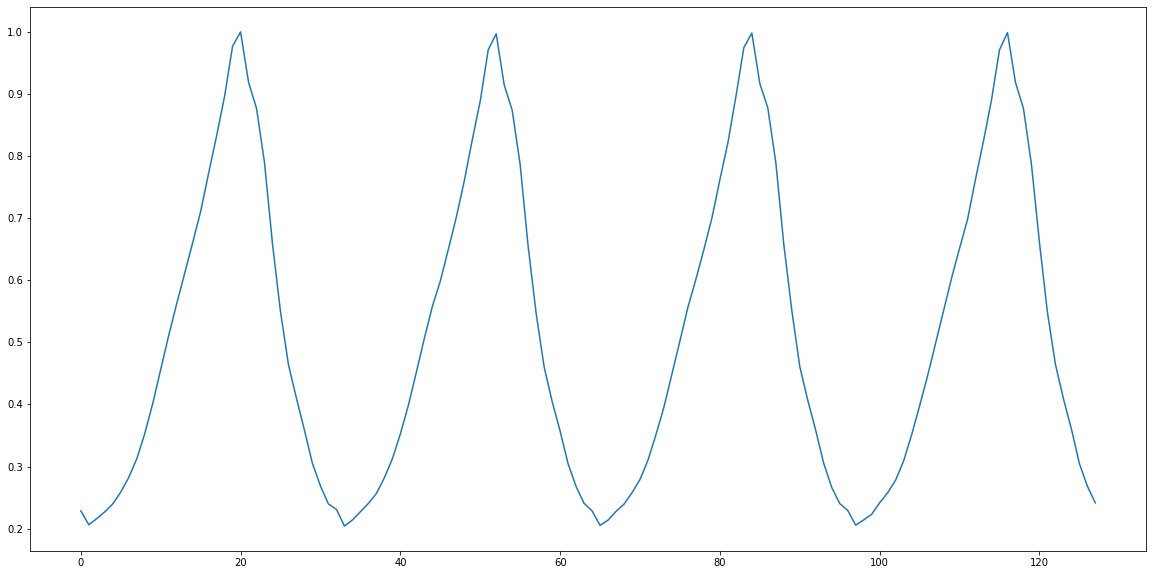

In [1176]:
plt.figure(figsize=(20,10))
trace = image.T.mean()
plt.plot(trace/trace.max())
plt.show()

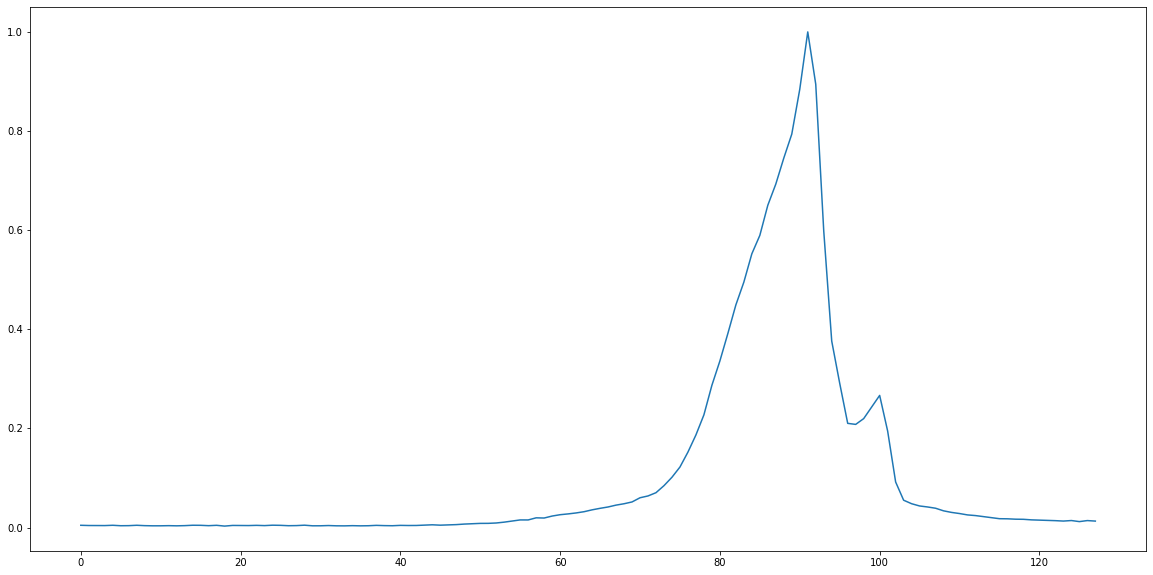

In [1186]:
plt.figure(figsize=(20,10))
trace = image.T.mean()
plt.plot(trace/trace.max())
plt.show()

In [1689]:
print(combined_section[6:27].T.max())

print("periodicity of {} samples".format(24-8))

2013-10-05 07:00:32.922020      48.0
2013-10-05 07:00:44.922020     602.0
2013-10-05 07:00:56.922020    6577.0
2013-10-05 07:01:08.922020    8223.0
2013-10-05 07:01:20.922020    7450.0
2013-10-05 07:01:32.922020    4987.0
2013-10-05 07:01:44.922020    1246.0
2013-10-05 07:01:56.922020     349.0
2013-10-05 07:02:08.922020      43.0
2013-10-05 07:02:20.922020      13.0
2013-10-05 07:02:32.984540      14.0
2013-10-05 07:02:44.984540      21.0
2013-10-05 07:02:56.984540     138.0
2013-10-05 07:03:08.984540      66.0
2013-10-05 07:03:20.984540      94.0
2013-10-05 07:03:32.984540      54.0
2013-10-05 07:03:44.984540      64.0
2013-10-05 07:03:56.984540     708.0
2013-10-05 07:04:08.984540    5837.0
2013-10-05 07:04:20.984540    7404.0
2013-10-05 07:04:32.984540    7300.0
dtype: float64
periodicity of 16 samples


In [1710]:
for i in range(16):
    print("{} {}".format(i,sliced_combined_section[i].median().median()))

0 117.17708333333334
1 98.125
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.25
8 1.0
9 0.0
10 314.5625
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
